In [ ]:
##Kerala_Precipition

In [ ]:
// 0. Load Indian states boundary and filter for Kerala
var states  = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala  = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala');

// 1. Define years and monsoon months
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 2. Define CHIRPS-style color palette
var chirpsPalette = [
  '#ffffcc', '#c7e9b4', '#7fcdbb',
  '#41b6c4', '#2c7fb8', '#225ea8',
  '#081d58'
];

// 3. Visualization parameters
var visMonth = {
  min:     0,
  max:     550 * 1.6,
  palette: chirpsPalette
};
var visTotal = {
  min:     0,
  max:     1762 * 1.6,
  palette: chirpsPalette
};

// 4. Build monthly & total rainfall bands
var allBands = [];

years.forEach(function(year) {
  var monthlyImages = [];
  
  months.forEach(function(m, idx) {
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');
    
    // Sum daily CHIRPS over the month
    var monthly = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
                    .filterDate(start, end)
                    .filterBounds(kerala)
                    .sum()
                    .clip(kerala)
                    .rename(year + '_' + monthNames[idx]);
    
    monthlyImages.push(monthly);
    allBands.push(monthly);
    
    // Visualize monthly
    Map.addLayer(monthly, visMonth, year + ' ' + monthNames[idx]);
  });
  
  // Compute monsoon total (June–September)
  var total = ee.Image.cat(monthlyImages)
                  .reduce(ee.Reducer.sum())
                  .rename(year + '_Total');
  allBands.push(total);
  
  // Visualize total
  Map.addLayer(total, visTotal, year + ' Total');
});

// 5. Concatenate all 25 bands into one image
var finalPrecip = ee.Image.cat(allBands);

// 6. Export the 25-band precipitation image to Google Drive
Export.image.toDrive({
  image:          finalPrecip,
  description:    'Kerala_Y_Precipitation_CHIRPS',
  folder:         'GEE_Exports',
  fileNamePrefix: 'Kerala_Y_Precipitation_CHIRPS',
  region:         kerala.geometry(),
  scale:          1000,
  crs:            'EPSG:4326',
  maxPixels:      1e13
});


2020 - Processing bands 0 to 3
2020 - June: min=98.84, max=1232.59


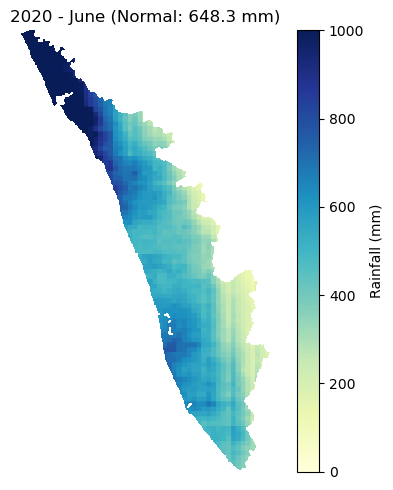

2020 - July: min=154.97, max=1278.73


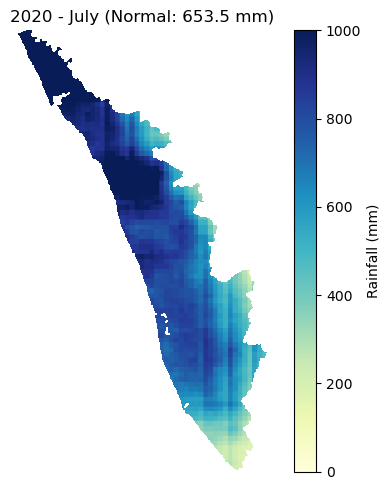

2020 - August: min=18.50, max=1242.74


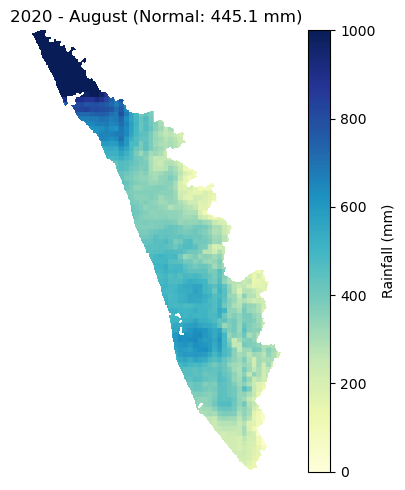

2020 - September: min=130.00, max=800.16


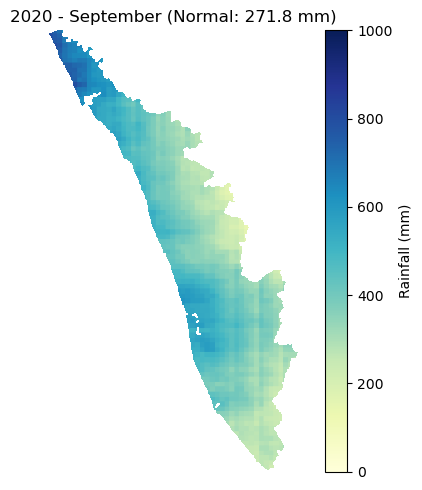

2020 - Total Precipitation (Kerala): min=582.39 mm, max=4440.16 mm


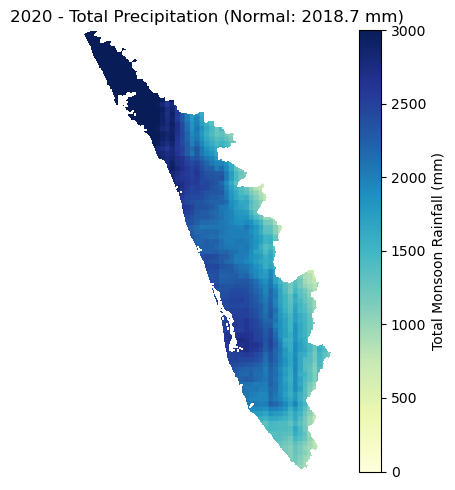


2021 - Processing bands 5 to 8
2021 - June: min=116.32, max=899.94


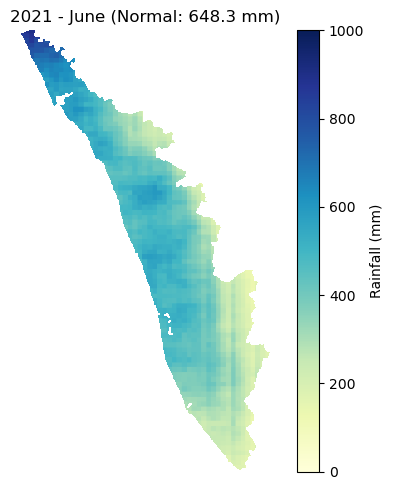

2021 - July: min=96.08, max=1205.54


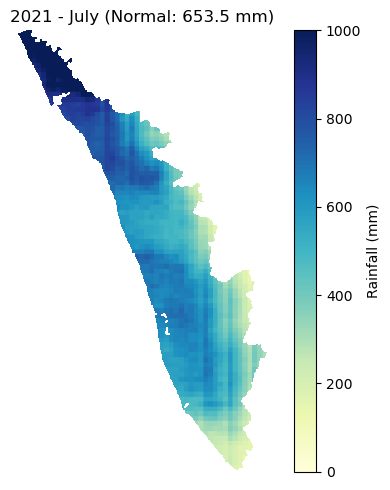

2021 - August: min=13.29, max=848.04


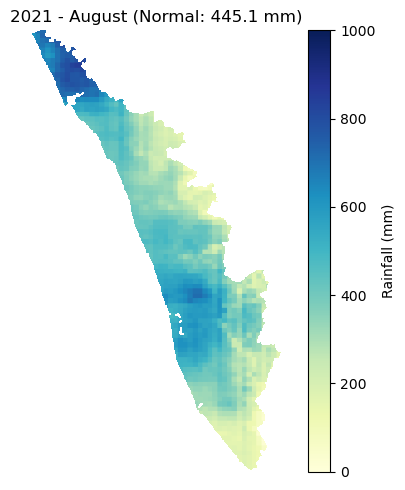

2021 - September: min=82.02, max=441.65


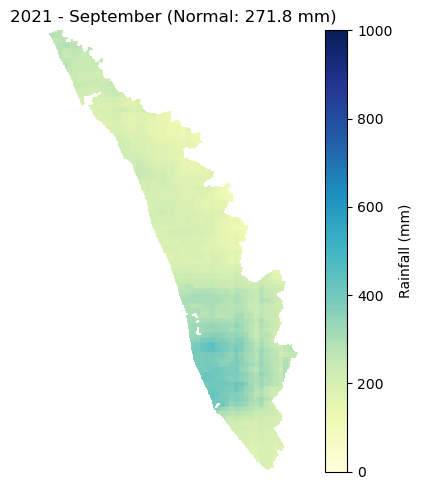

2021 - Total Precipitation (Kerala): min=460.64 mm, max=3095.46 mm


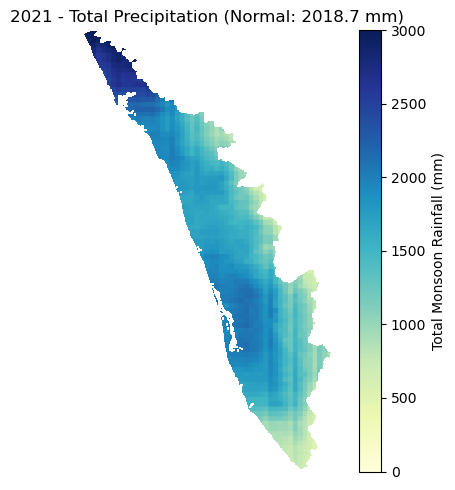


2022 - Processing bands 10 to 13
2022 - June: min=100.12, max=905.45


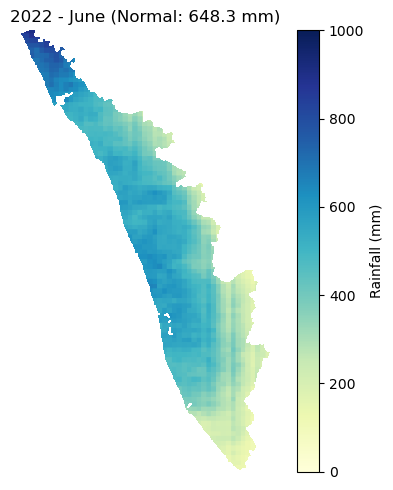

2022 - July: min=205.12, max=1555.35


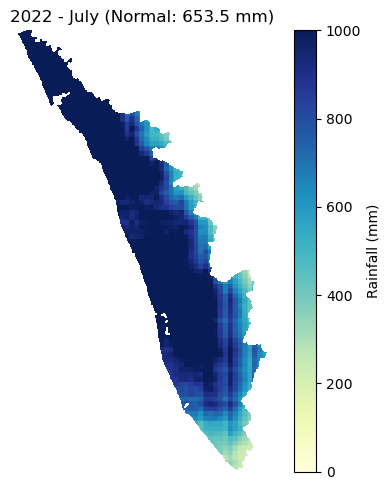

2022 - August: min=43.57, max=1258.30


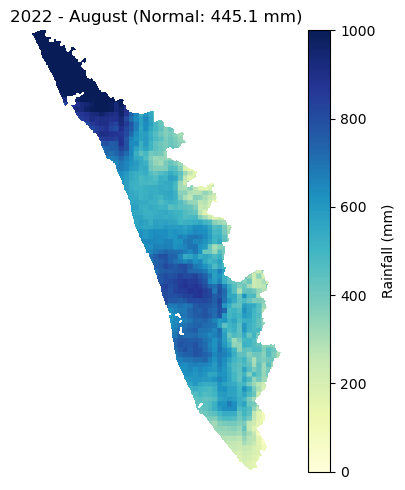

2022 - September: min=60.62, max=329.01


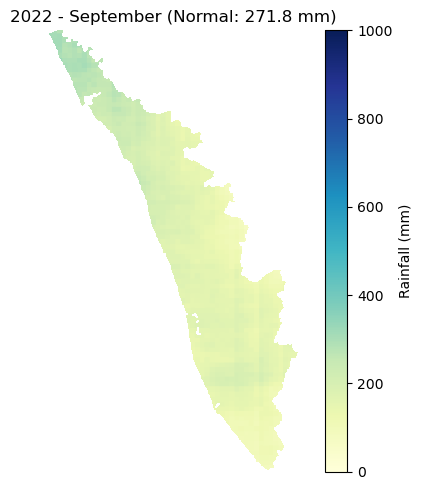

2022 - Total Precipitation (Kerala): min=505.37 mm, max=3831.62 mm


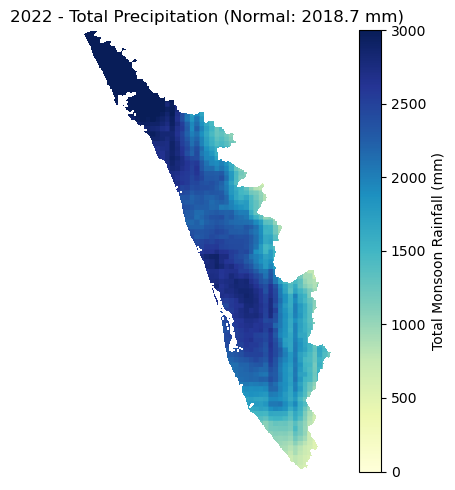


2023 - Processing bands 15 to 18
2023 - June: min=156.47, max=1700.35


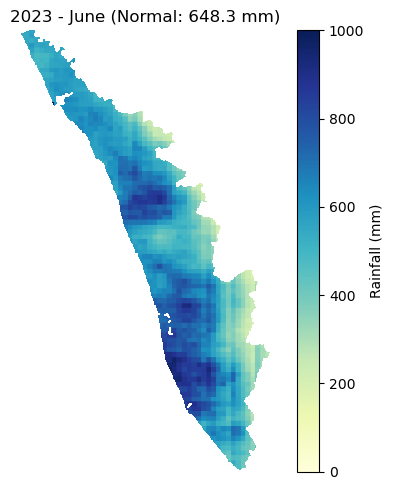

2023 - July: min=77.89, max=1553.45


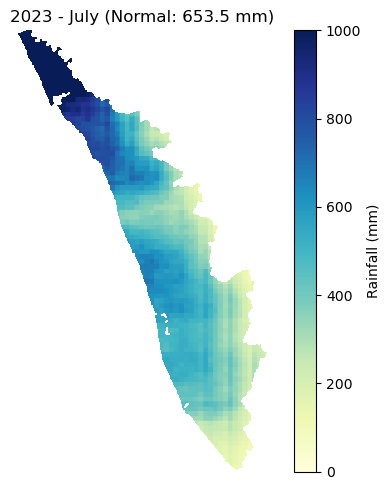

2023 - August: min=10.74, max=264.95


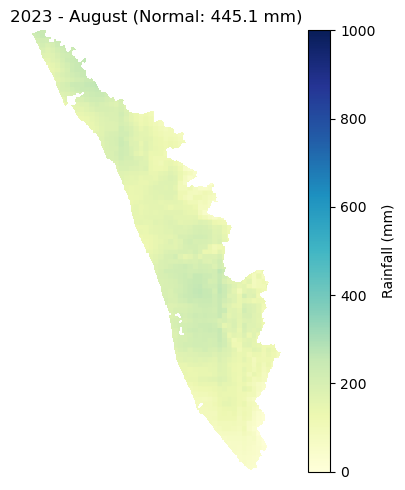

2023 - September: min=54.20, max=421.64


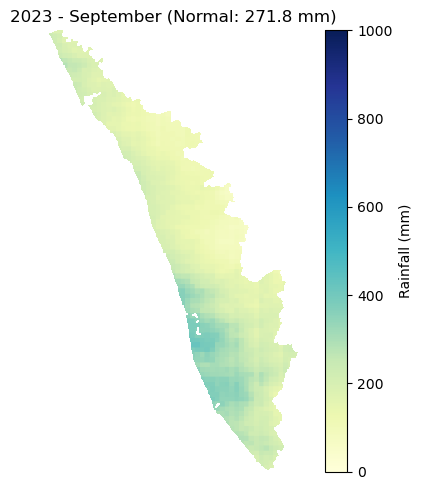

2023 - Total Precipitation (Kerala): min=393.37 mm, max=3076.54 mm


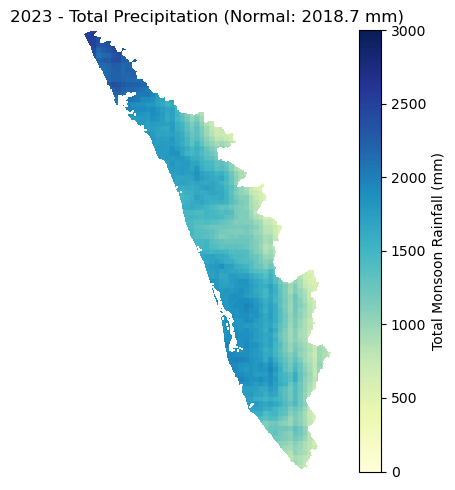


2024 - Processing bands 20 to 23
2024 - June: min=139.57, max=1157.80


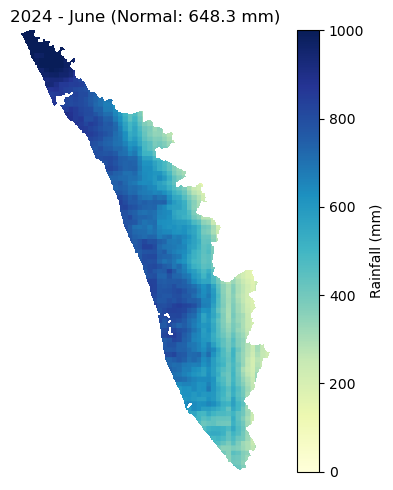

2024 - July: min=126.80, max=1703.40


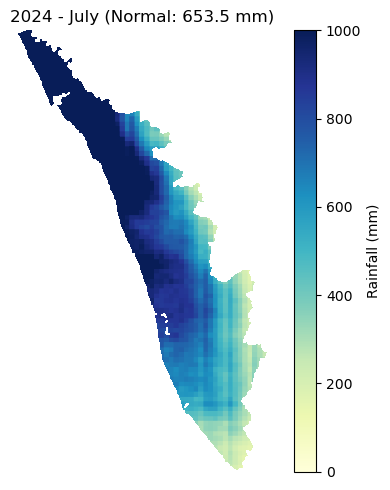

2024 - August: min=10.73, max=1487.02


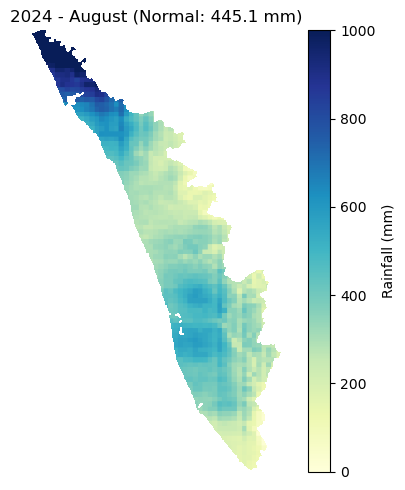

2024 - September: min=25.36, max=270.35


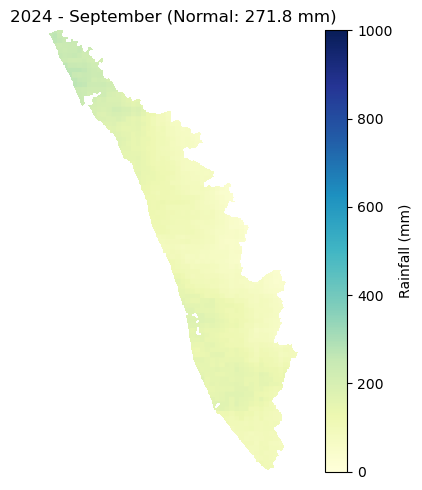

2024 - Total Precipitation (Kerala): min=402.39 mm, max=4574.57 mm


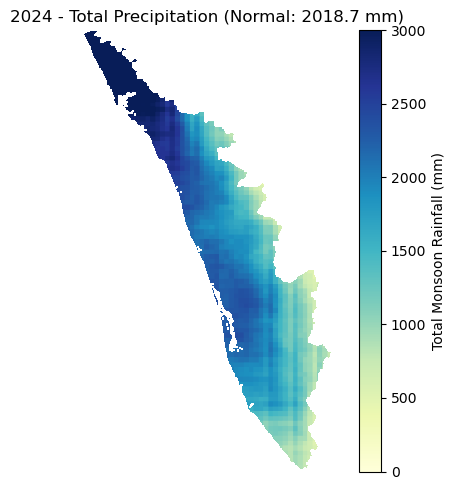

In [77]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.io import MemoryFile

# --- Configuration for Kerala ---
tiff_path        = "Kerala_Y_Precipitation_CHIRPS.tif"
shapefile_path   = "SateMask/gadm41_IND_1.shp"
years            = [2020, 2021, 2022, 2023, 2024]
band_names       = ['June', 'July', 'August', 'September']
normal           = [648.3, 653.5, 445.1, 271.8]  # June, July, August, September
total_normal     = 2018.7
monthly_vmin, monthly_vmax = 0, 1000
total_vmin, total_vmax     = 0, 3000
bands_per_year   = 5  # 4 monsoon months + 1 total band

# --- Load Kerala boundary from shapefile ---
gdf = gpd.read_file(shapefile_path)
gdf_kerala = gdf[gdf["NAME_1"] == "Kerala"]
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")
kerala_geom  = gdf_kerala.geometry.values[0]
geojson_geom = [kerala_geom.__geo_interface__]

# --- Load rainfall TIFF ---
if not os.path.exists(tiff_path):
    raise FileNotFoundError(f"{tiff_path} not found.")

with rasterio.open(tiff_path) as src:
    all_bands = src.read().astype(float)  # shape = (years*5, H, W)
    height, width = src.height, src.width
    transform     = src.transform
    crs           = src.crs

    # Determine if values need scaling (e.g. raw CHIRPS sums)
    needs_scaling = np.nanmax(all_bands) > 2000

    for year_idx, year in enumerate(years):
        start = year_idx * bands_per_year
        monsoon_bands = all_bands[start:start + 4]

        print(f"\n{year} - Processing bands {start} to {start + 3}")

        # --- Plot each monsoon month ---
        for i in range(4):
            band = monsoon_bands[i]
            print(f"{year} - {band_names[i]}: min={np.nanmin(band):.2f}, max={np.nanmax(band):.2f}")

            plt.figure(figsize=(6, 5))
            plt.imshow(band, cmap='YlGnBu', vmin=monthly_vmin, vmax=monthly_vmax)
            plt.colorbar(label='Rainfall (mm)')
            plt.title(f"{year} - {band_names[i]} (Normal: {normal[i]} mm)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        # --- Compute total monsoon rainfall ---
        if needs_scaling:
            monsoon_bands *= 1  # adjust scaling if necessary

        total_precip = np.nansum(monsoon_bands, axis=0)

        # --- Mask total_precip to Kerala region ---
        with MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=total_precip.shape[0],
                width=total_precip.shape[1],
                count=1,
                dtype='float32',
                transform=transform,
                crs=crs
            ) as tmp_ds:
                tmp_ds.write(total_precip.astype('float32'), 1)
                masked, _ = mask(tmp_ds, geojson_geom, crop=False, filled=True, nodata=np.nan)
                total_masked = masked[0]
                # Remove zeros outside region
                total_masked[total_masked == 0] = np.nan

        # --- Plot total rainfall ---
        tmin = np.nanmin(total_masked)
        tmax = np.nanmax(total_masked)
        print(f"{year} - Total Precipitation (Kerala): min={tmin:.2f} mm, max={tmax:.2f} mm")

        plt.figure(figsize=(6, 5))
        plt.imshow(total_masked, cmap='YlGnBu', vmin=total_vmin, vmax=total_vmax)
        plt.colorbar(label='Total Monsoon Rainfall (mm)')
        plt.title(f"{year} - Total Precipitation (Normal: {total_normal} mm)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


Categorical GeoTIFF saved as: Kerala_Y_Precipitation_GT_geotif.tif


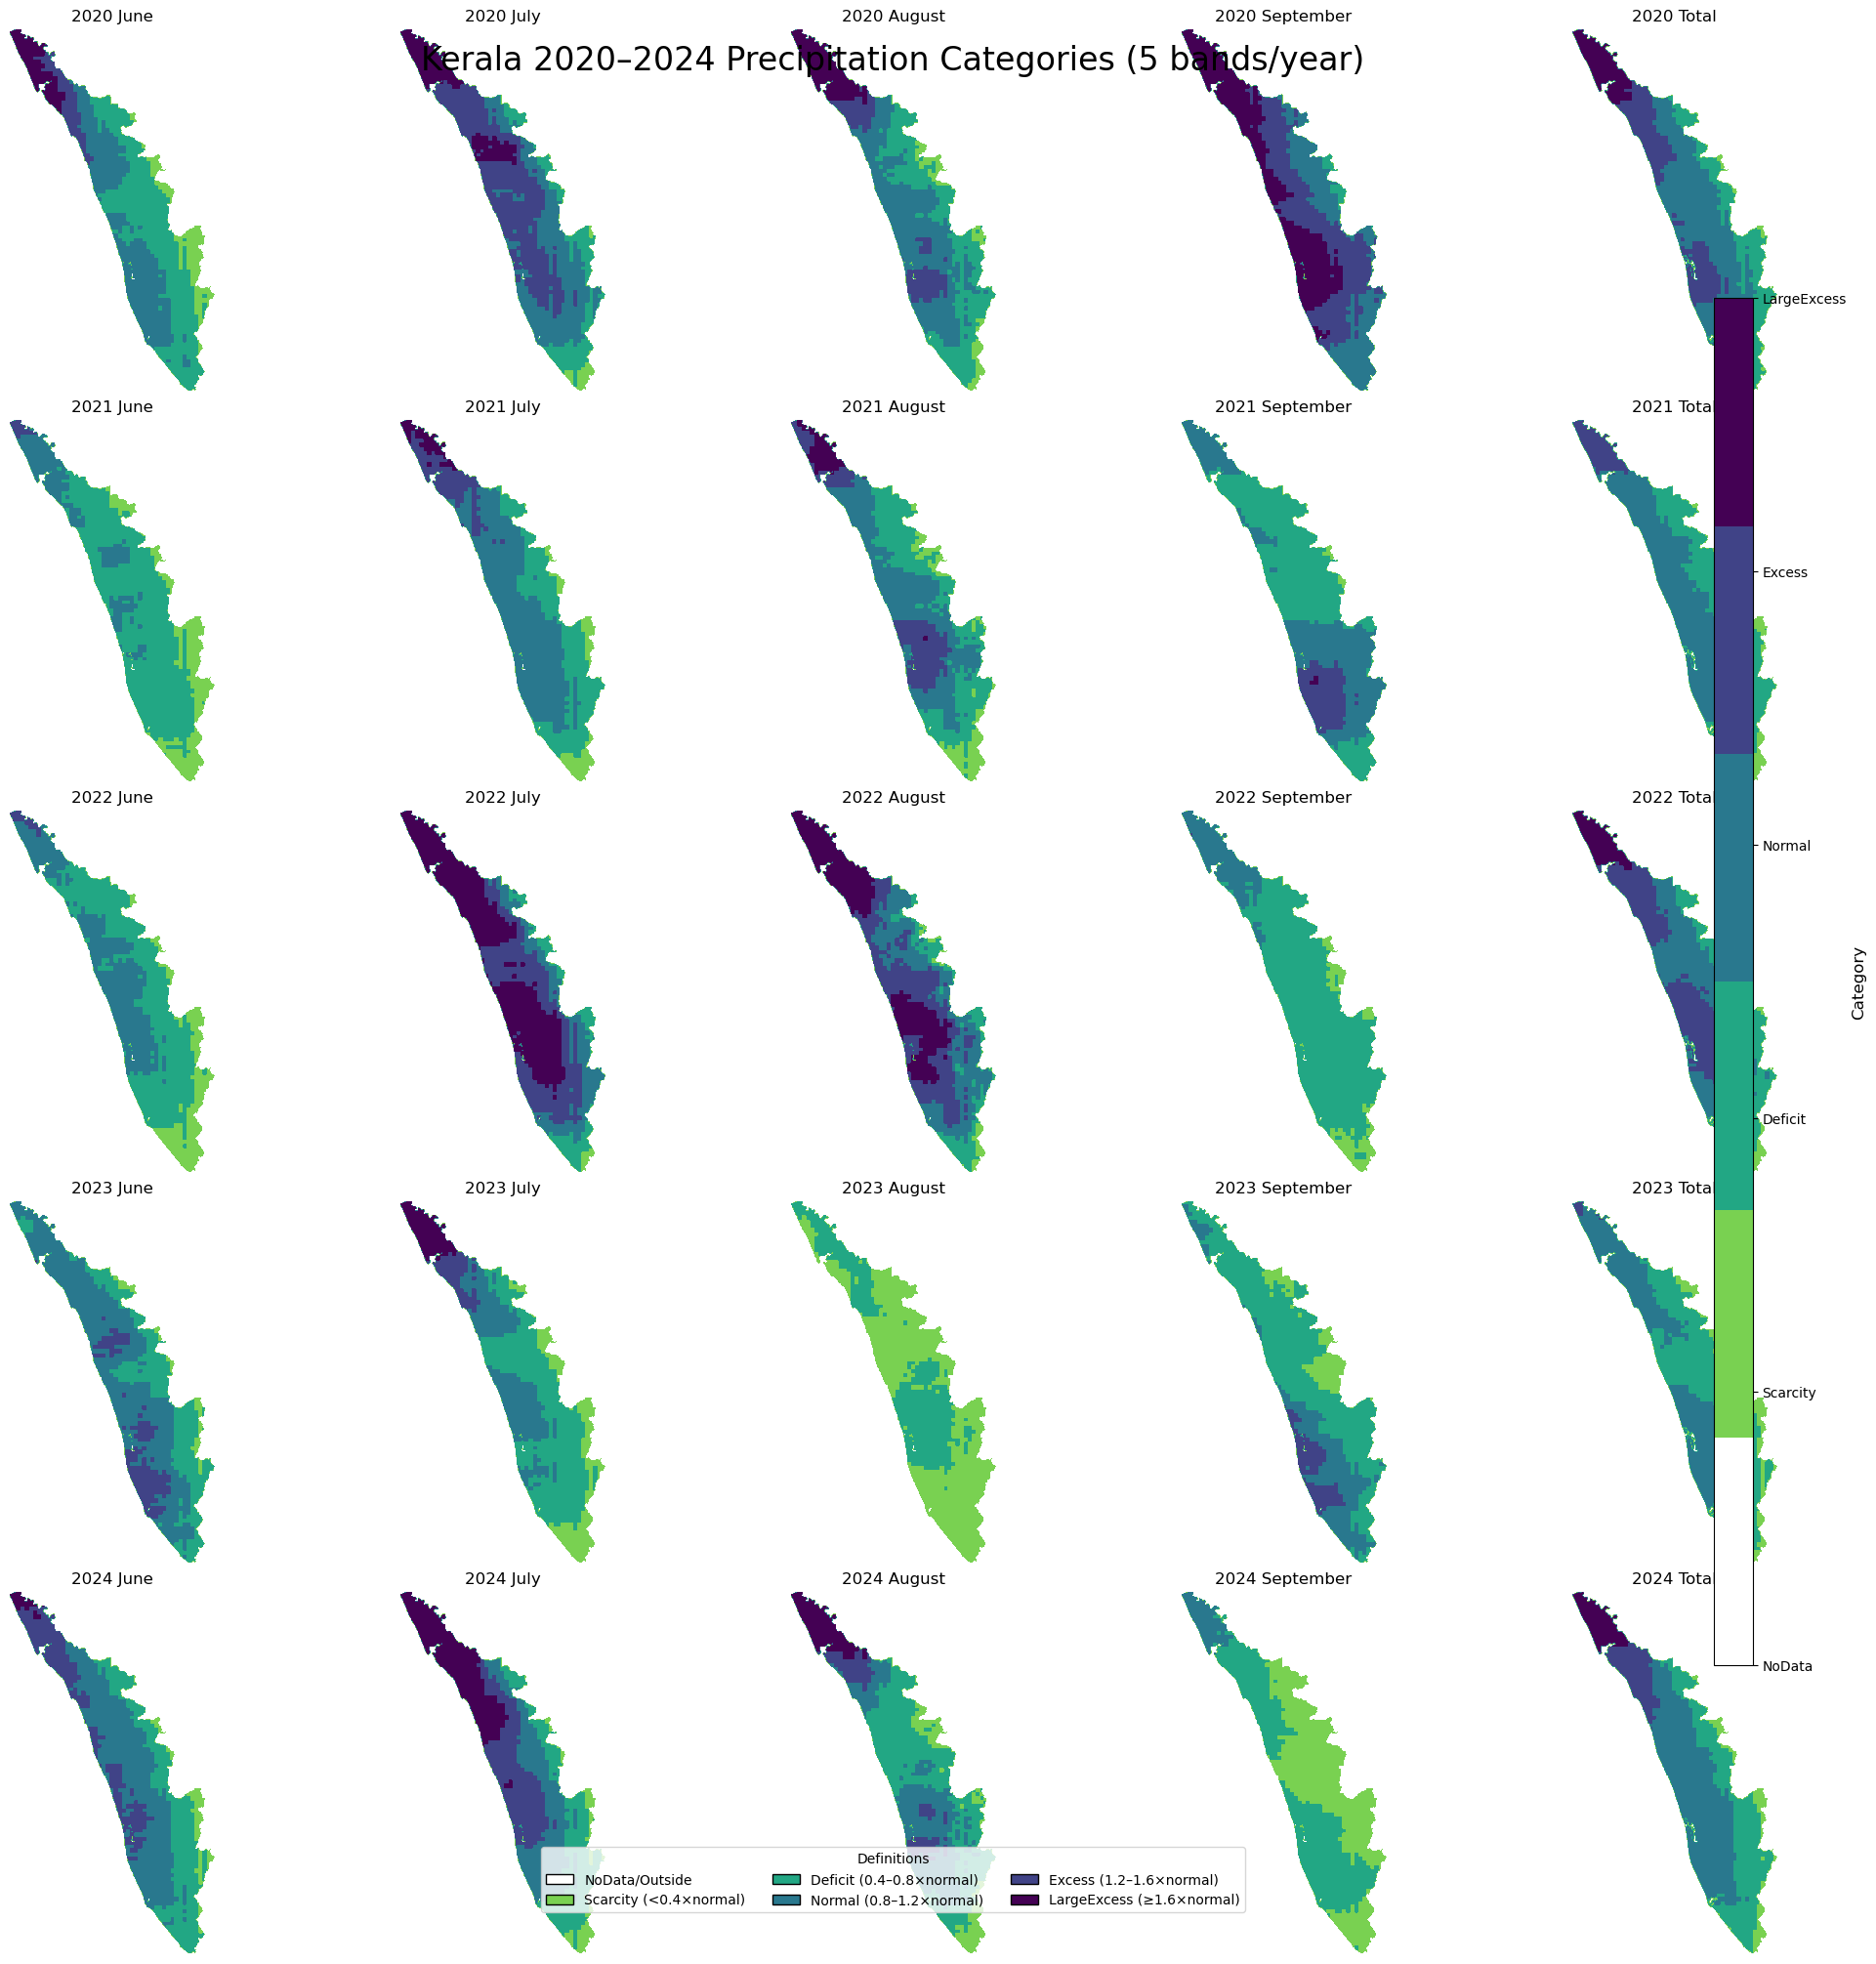

In [86]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from rasterio.io import MemoryFile
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# -----------------------------------------------------------------------------
# 1) PATH TO YOUR 25‐BAND PRECIPITATION TIFF FOR KERALA
# -----------------------------------------------------------------------------
tiff_path = "Kerala_Y_Precipitation_CHIRPS.tif"
if not os.path.isfile(tiff_path):
    raise FileNotFoundError(f"Cannot find {tiff_path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ ALL 25 BANDS INTO A NumPy ARRAY
# -----------------------------------------------------------------------------
with rasterio.open(tiff_path) as src:
    all_bands = src.read().astype(np.float32)  # shape = (25, H, W)
    profile   = src.profile.copy()
    height, width = src.height, src.width

n_bands = all_bands.shape[0]
if n_bands != 25:
    raise ValueError(f"Expected 25 bands (2020–2024 × 5), but found {n_bands}")

# -----------------------------------------------------------------------------
# 3) DEFINE “NORMAL” VALUES FOR KERALA (June, July, August, September, Total)
# -----------------------------------------------------------------------------
normals = np.array([
    648.3,  # June
    653.5,  # July
    445.1,  # August
    271.8,  # September
    2018.7  # Total Monsoon
], dtype=np.float32)

# -----------------------------------------------------------------------------
# 4) CATEGORY THRESHOLDS (as MULTIPLES of “NORMAL”)
# -----------------------------------------------------------------------------
def categorize_precip(band_data: np.ndarray, normal_value: float) -> np.ndarray:
    cat = np.full(band_data.shape, -1, dtype=np.int8)
    mask_valid = ~np.isnan(band_data)
    vals = band_data[mask_valid]
    r = vals / normal_value

    c = np.full(vals.shape, -1, dtype=np.int8)
    c[r < 0.4]              = 0  # Scarcity
    c[(r >= 0.4) & (r < 0.8)] = 1  # Deficit
    c[(r >= 0.8) & (r < 1.2)] = 2  # Normal
    c[(r >= 1.2) & (r < 1.6)] = 3  # Excess
    c[r >= 1.6]              = 4  # LargeExcess

    cat[mask_valid] = c
    return cat

# -----------------------------------------------------------------------------
# 5) APPLY CATEGORIZATION TO ALL 25 BANDS
# -----------------------------------------------------------------------------
category_stack = np.full(all_bands.shape, -1, dtype=np.int8)
for i in range(n_bands):
    idx = i % 5
    category_stack[i] = categorize_precip(all_bands[i], normals[idx])

# -----------------------------------------------------------------------------
# 6) EXPORT THE CATEGORY STACK AS A NEW 25‐BAND GeoTIFF
#    Filename: “Kerala_Y_Precipitation_GT_geotif.tif”
# -----------------------------------------------------------------------------
out_profile = profile.copy()
out_profile.update(count=25, dtype=rasterio.int8, nodata=-1)

output_path = "Kerala_Y_Precipitation_GT_geotif.tif"
with rasterio.open(output_path, "w", **out_profile) as dst:
    dst.write(category_stack)

print(f"Categorical GeoTIFF saved as: {output_path}")

# -----------------------------------------------------------------------------
# 7) SET UP A DISCRETE COLORMAP FOR THE 5 CATEGORIES + “NoData” AS WHITE
# -----------------------------------------------------------------------------
colors = [
    "#ffffff",  # 0 = NoData
    "#79d151",  # 1 = Scarcity
    "#22a784",  # 2 = Deficit
    "#29788e",  # 3 = Normal
    "#404387",  # 4 = Excess
    "#440154"   # 5 = LargeExcess
]
cmap = ListedColormap(colors)
labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit (0.4–0.8×normal)",
    3: "Normal (0.8–1.2×normal)",
    4: "Excess (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
handles = [Patch(facecolor=colors[i], edgecolor="black", label=labels[i]) for i in labels]

# -----------------------------------------------------------------------------
# 8) VISUALIZE ALL 25 CATEGORY LAYERS IN A 5×5 GRID
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September", "Total"]

fig, axes = plt.subplots(5, 5, figsize=(20, 20), constrained_layout=True)
fig.suptitle("Kerala 2020–2024 Precipitation Categories (5 bands/year)", fontsize=24, y=0.98)

for i in range(n_bands):
    r, c = divmod(i, 5)
    ax = axes[r, c]

    layer = category_stack[i]
    plot_arr = np.zeros_like(layer, dtype=np.int8)
    valid = layer != -1
    plot_arr[valid] = layer[valid] + 1  # shift codes 0→1…4→5;  -1→0

    ax.imshow(plot_arr, cmap=cmap, vmin=0, vmax=5)
    ax.set_title(f"{years[r]} {month_names[c]}", fontsize=12)
    ax.axis("off")

# colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=5)),
    cax=cax, ticks=[0,1,2,3,4,5]
)
cb.ax.set_yticklabels(["NoData","Scarcity","Deficit","Normal","Excess","LargeExcess"])
cb.set_label("Category", rotation=90, fontsize=12)

# legend
fig.legend(handles=handles, loc="lower center", ncol=3, frameon=True,
           title="Definitions", bbox_to_anchor=(0.5, 0.02))

plt.show()


In [ ]:
##Kerala_X_LST

In [ ]:
// 0. Load Indian states boundary and filter for Kerala
var states  = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala  = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala');

// 1. Define years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 2. Visualization parameters for LST (°C)
var visLST = {
  min:     0,
  max:     50,
  palette: ['blue', 'green', 'yellow', 'orange', 'red']
};

// 3. Collect all monthly‐mean LST bands (4 months × 5 years = 20 bands)
var allBands = [];

years.forEach(function(year) {
  months.forEach(function(m, idx) {
    // 3a. Define start and end of the month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');
    
    // 3b. Compute monthly‐mean LST from MODIS
    var monthlyLST = ee.ImageCollection('MODIS/061/MOD11A1')
      .filterDate(start, end)
      .filterBounds(kerala)
      .select('LST_Day_1km')
      .mean()
      .multiply(0.02)        // scale factor
      .subtract(273.15)      // Kelvin → Celsius
      .clip(kerala)
      .rename(year + '_' + monthNames[idx] + '_LST');
    
    allBands.push(monthlyLST);
    
    // 3c. Visualize monthly LST
    Map.addLayer(
      monthlyLST,
      visLST,
      year + ' ' + monthNames[idx] + ' LST'
    );
  });
});

// 4. Stack all 20 bands into one multi‐band image
var finalImage = ee.Image.cat(allBands);

// 5. Export that 20‐band image to Google Drive
Export.image.toDrive({
  image:          finalImage,
  description:    'Kerala_X_LST',
  folder:         'GEE_Exports',
  fileNamePrefix: 'Kerala_X_LST',
  region:         kerala.geometry(),
  scale:          1000,       // native resolution of MOD11A1
  crs:            'EPSG:4326',
  maxPixels:      1e13
});

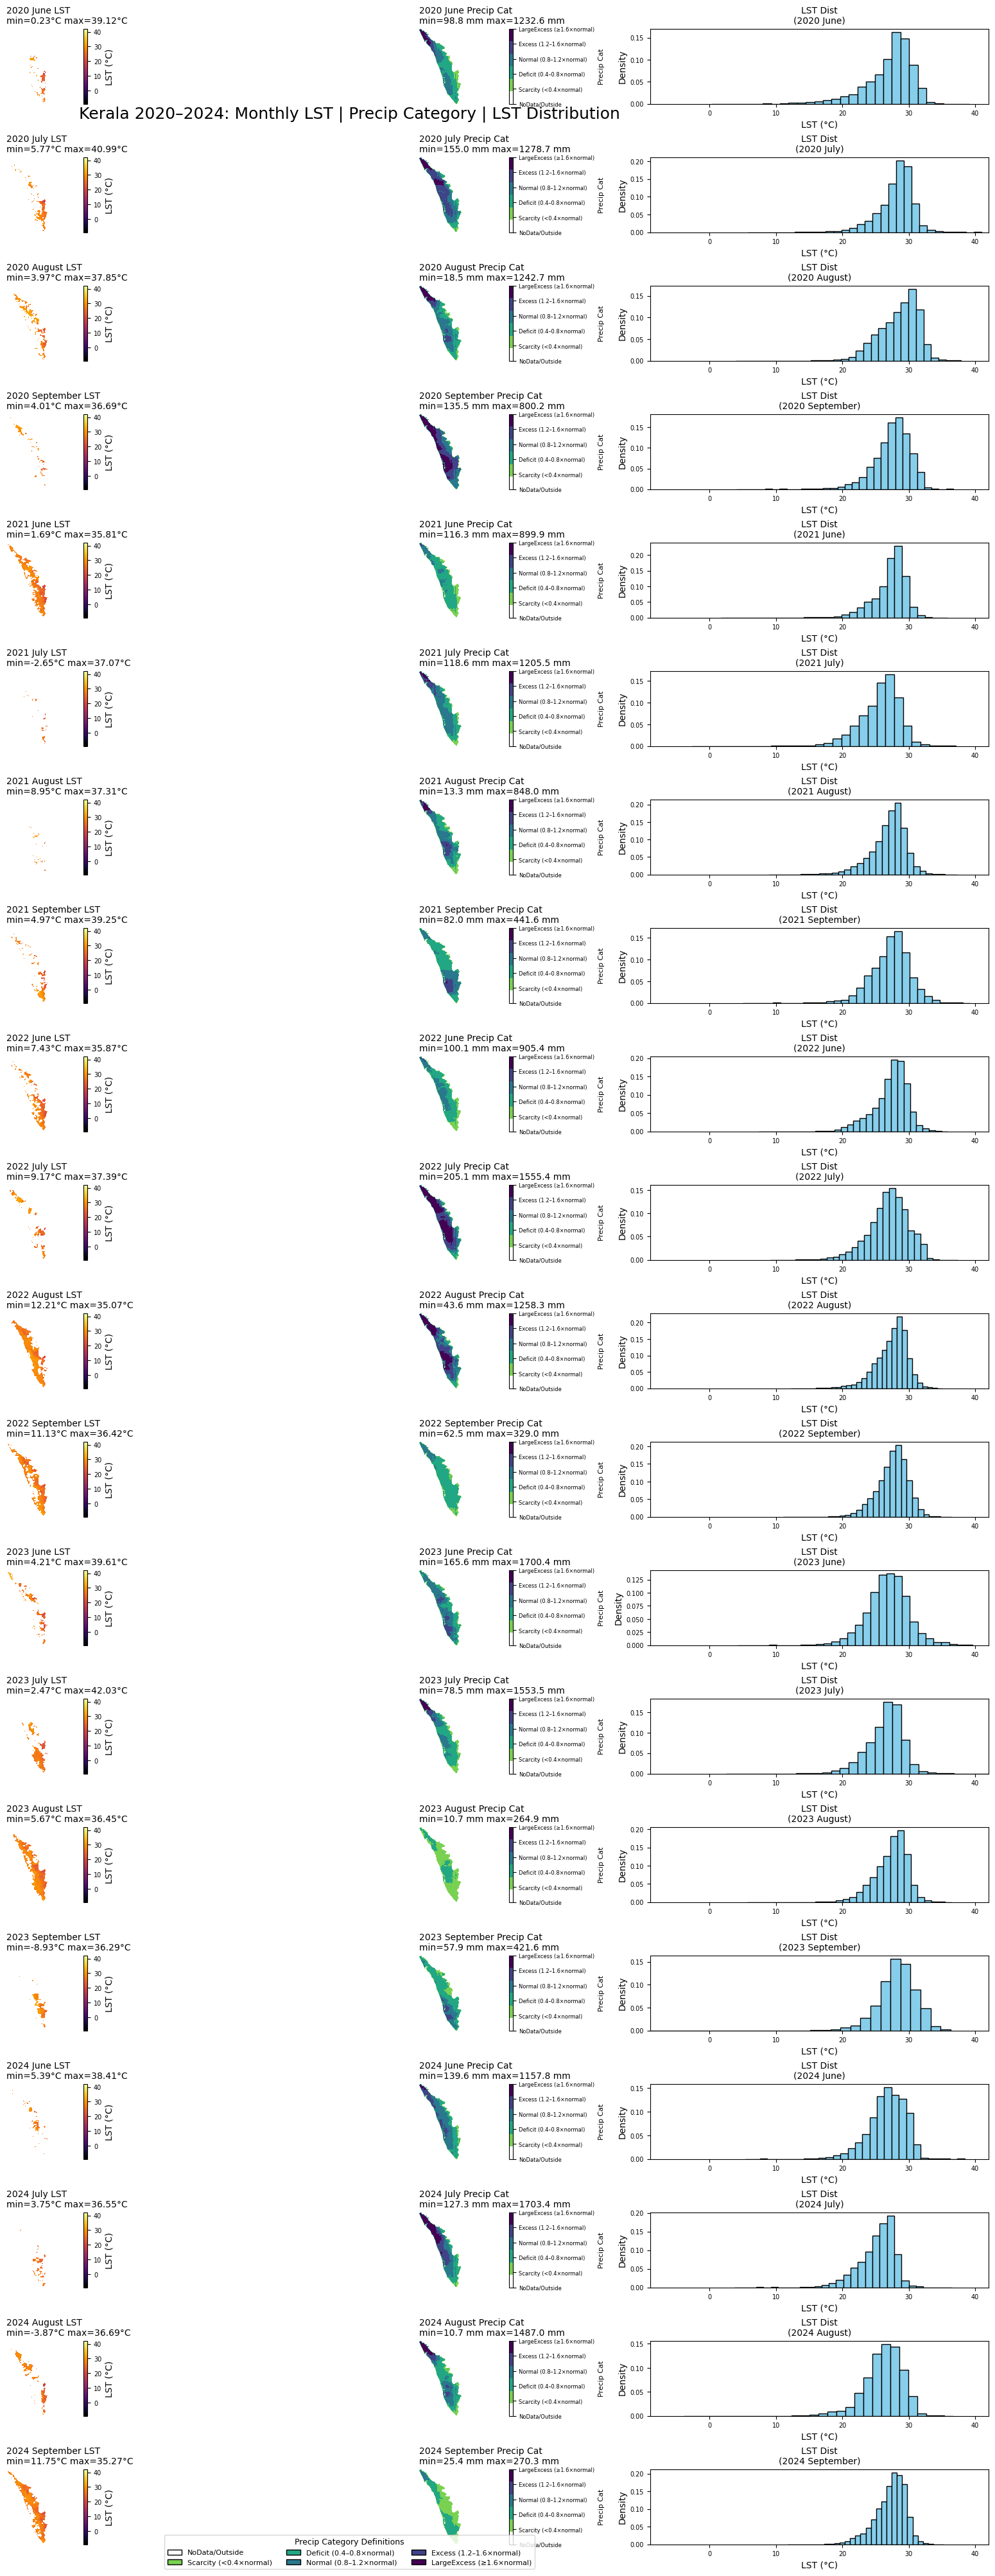

In [94]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust as needed)
#    - LST TIFF:               20 bands (2020–2024 × 4 months: June–September)
#    - Precipitation RAW TIFF: 25 bands (2020–2024 × 5 bands: June–September + Total)
#    - Precipitation Category: 25 bands (2020–2024 × 5 category bands)
#    - Kerala shapefile        : SateMask/gadm41_IND_1.shp
# -----------------------------------------------------------------------------
lst_tiff_path        = "Kerala_X_LST.tif"
precip_raw_tiff_path = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path = "Kerala_Y_Precipitation_GT_geotif.tif"
shapefile_path       = "SateMask/gadm41_IND_1.shp"

for p in (lst_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, shapefile_path):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD KERALA BOUNDARY
# -----------------------------------------------------------------------------
gdf = gpd.read_file(shapefile_path)
gdf_kerala = gdf[gdf["NAME_1"] == "Kerala"]
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")
kerala_geom = [gdf_kerala.geometry.values[0].__geo_interface__]

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 20‐BAND LST TIFF
# -----------------------------------------------------------------------------
with rasterio.open(lst_tiff_path) as src:
    lst_bands, _ = mask(src, kerala_geom, crop=False, filled=True, nodata=np.nan)
    lst_bands = lst_bands.astype(np.float32)  # shape = (20, H, W)
    profile   = src.profile.copy()

n_lst_bands = lst_bands.shape[0]
if n_lst_bands != 20:
    raise ValueError(f"Expected 20 bands in {lst_tiff_path}, but found {n_lst_bands}")

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25‐BAND RAW PRECIPITATION TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full, _ = mask(src, kerala_geom, crop=False, filled=True, nodata=np.nan)
    pr_raw_full = pr_raw_full.astype(np.float32)  # shape = (25, H, W)

n_pr_raw = pr_raw_full.shape[0]
if n_pr_raw != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, but found {n_pr_raw}")

# -----------------------------------------------------------------------------
# 5) READ & MASK THE 25‐BAND PRECIPITATION CATEGORY TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full, _ = mask(src, kerala_geom, crop=False, filled=True, nodata=-1)
    pr_cat_full = pr_cat_full.astype(np.int8)  # shape = (25, H, W)

n_pr_cat = pr_cat_full.shape[0]
if n_pr_cat != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, but found {n_pr_cat}")

# -----------------------------------------------------------------------------
# 6) EXTRACT ONLY THE 20 MONTHLY PRECIP BANDS
# -----------------------------------------------------------------------------
monthly_indices = []
for y in range(5):
    base = y * 5
    monthly_indices.extend([base + i for i in range(4)])
precip_raw_bands = pr_raw_full[monthly_indices, :, :]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_indices, :, :]  # (20, H, W)

# -----------------------------------------------------------------------------
# 7) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 8) SET UP COLORMAPS & STATS
# -----------------------------------------------------------------------------
# LST
all_lst = lst_bands.flatten()
all_lst = all_lst[~np.isnan(all_lst)]
lst_vmin = float(np.nanmin(all_lst)) if all_lst.size else 0.0
lst_vmax = float(np.nanmax(all_lst)) if all_lst.size else 50.0
lst_cmap = plt.get_cmap("inferno")

# Precip categories
cluster_colors = [
    "#ffffff", "#79d151", "#22a784",
    "#29788e", "#404387", "#440154"
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit (0.4–0.8×normal)",
    3: "Normal (0.8–1.2×normal)",
    4: "Excess (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# -----------------------------------------------------------------------------
# 9) PLOT: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total, ncols=3,
    figsize=(20, n_total * 2.0),
    constrained_layout=True
)
fig.suptitle(
    "Kerala 2020–2024: Monthly LST | Precip Category | LST Distribution",
    fontsize=18, y=0.96
)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    yr = years[i // n_months]
    mo = month_names[i % n_months]

    # LST map
    layer_lst = lst_bands[i]
    v = layer_lst[~np.isnan(layer_lst)]
    mn, mx = (float(np.nanmin(v)), float(np.nanmax(v))) if v.size else (np.nan, np.nan)
    ax0 = axes[i, 0]
    im0 = ax0.imshow(layer_lst, cmap=lst_cmap, vmin=lst_vmin, vmax=lst_vmax)
    ax0.set_title(f"{yr} {mo} LST\nmin={mn:.2f}°C max={mx:.2f}°C", loc="left", fontsize=10)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.04, pad=0.04)
    c0.set_label("LST (°C)"); c0.ax.tick_params(labelsize=7)

    # Precip category map
    pr_layer = precip_raw_bands[i]
    vpr = pr_layer[~np.isnan(pr_layer)]
    pmin, pmax = (float(np.nanmin(vpr)), float(np.nanmax(vpr))) if vpr.size else (np.nan, np.nan)
    raw_cat = precip_cat_bands[i]
    cat_plot = np.zeros(raw_cat.shape, dtype=np.int8)
    mask_val = raw_cat != -1
    cat_plot[mask_val] = raw_cat[mask_val] + 1
    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5)
    ax1.set_title(f"{yr} {mo} Precip Cat\nmin={pmin:.1f} mm max={pmax:.1f} mm", loc="left", fontsize=10)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.04, pad=0.04)
    c1.set_ticks(range(6)); c1.set_ticklabels([cluster_labels[k] for k in range(6)]); c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Cat", fontsize=8)

    # LST histogram
    ax2 = axes[i, 2]
    if v.size:
        ax2.hist(v, bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(lst_vmin, lst_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"LST Dist\n({yr} {mo})", fontsize=10)
    ax2.set_xlabel("LST (°C)"); ax2.set_ylabel("Density"); ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) ADD LEGEND FOR PRECIPITATION CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precip Category Definitions",
    bbox_to_anchor=(0.5, 0.00),
    fontsize=8,
    title_fontsize=9
)

plt.show()


In [ ]:
##Kerala_X_NVDI

In [ ]:
// 0. Load Indian states boundary and filter for Kerala
var states = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala');

// 1. Define years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 2. Visualization parameters for NDVI (–1 to 1) with eight‐color palette
var visNDVI = {
  min: -1,
  max: 1,
  palette: [
    'brown',      // very low NDVI
    'red',
    'orange',
    'yellow',
    'lightblue',
    'navy',
    'lightgreen',
    'green'       // very high NDVI
  ]
};

// 3. Collect all monthly‐mean NDVI bands (4 months × 5 years = 20 bands)
var allBands = [];

years.forEach(function(year) {
  months.forEach(function(m, idx) {
    // 3a. Define start and end of the month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');
    
    // 3b. Compute monthly‐mean NDVI using MODIS/061/MOD13A2
    var monthlyNDVI = ee.ImageCollection('MODIS/061/MOD13A2')
      .filterDate(start, end)
      .filterBounds(kerala)
      .select('NDVI')
      .mean()
      .multiply(0.0001)       // scale factor per MODIS docs
      .clip(kerala)
      .rename(year + '_' + monthNames[idx] + '_NDVI');
    
    allBands.push(monthlyNDVI);
    
    // 3c. Visualize on the map
    Map.addLayer(
      monthlyNDVI,
      visNDVI,
      year + ' ' + monthNames[idx] + ' NDVI'
    );
  });
});

// 4. Stack all 20 bands into one multi‐band image
var finalImage = ee.Image.cat(allBands);

// 5. Export that 20‐band image to Google Drive as a single GeoTIFF
Export.image.toDrive({
  image:          finalImage,
  description:    'Kerala_X_NDVI',
  folder:         'GEE_Exports',    // change folder if desired
  fileNamePrefix: 'Kerala_X_NDVI',  // output file will be “Kerala_X_NDVI.tif”
  region:         kerala.geometry(),
  scale:          1000,             // 500 m native resolution of MOD13A2
  crs:            'EPSG:4326',
  maxPixels:      1e13
});



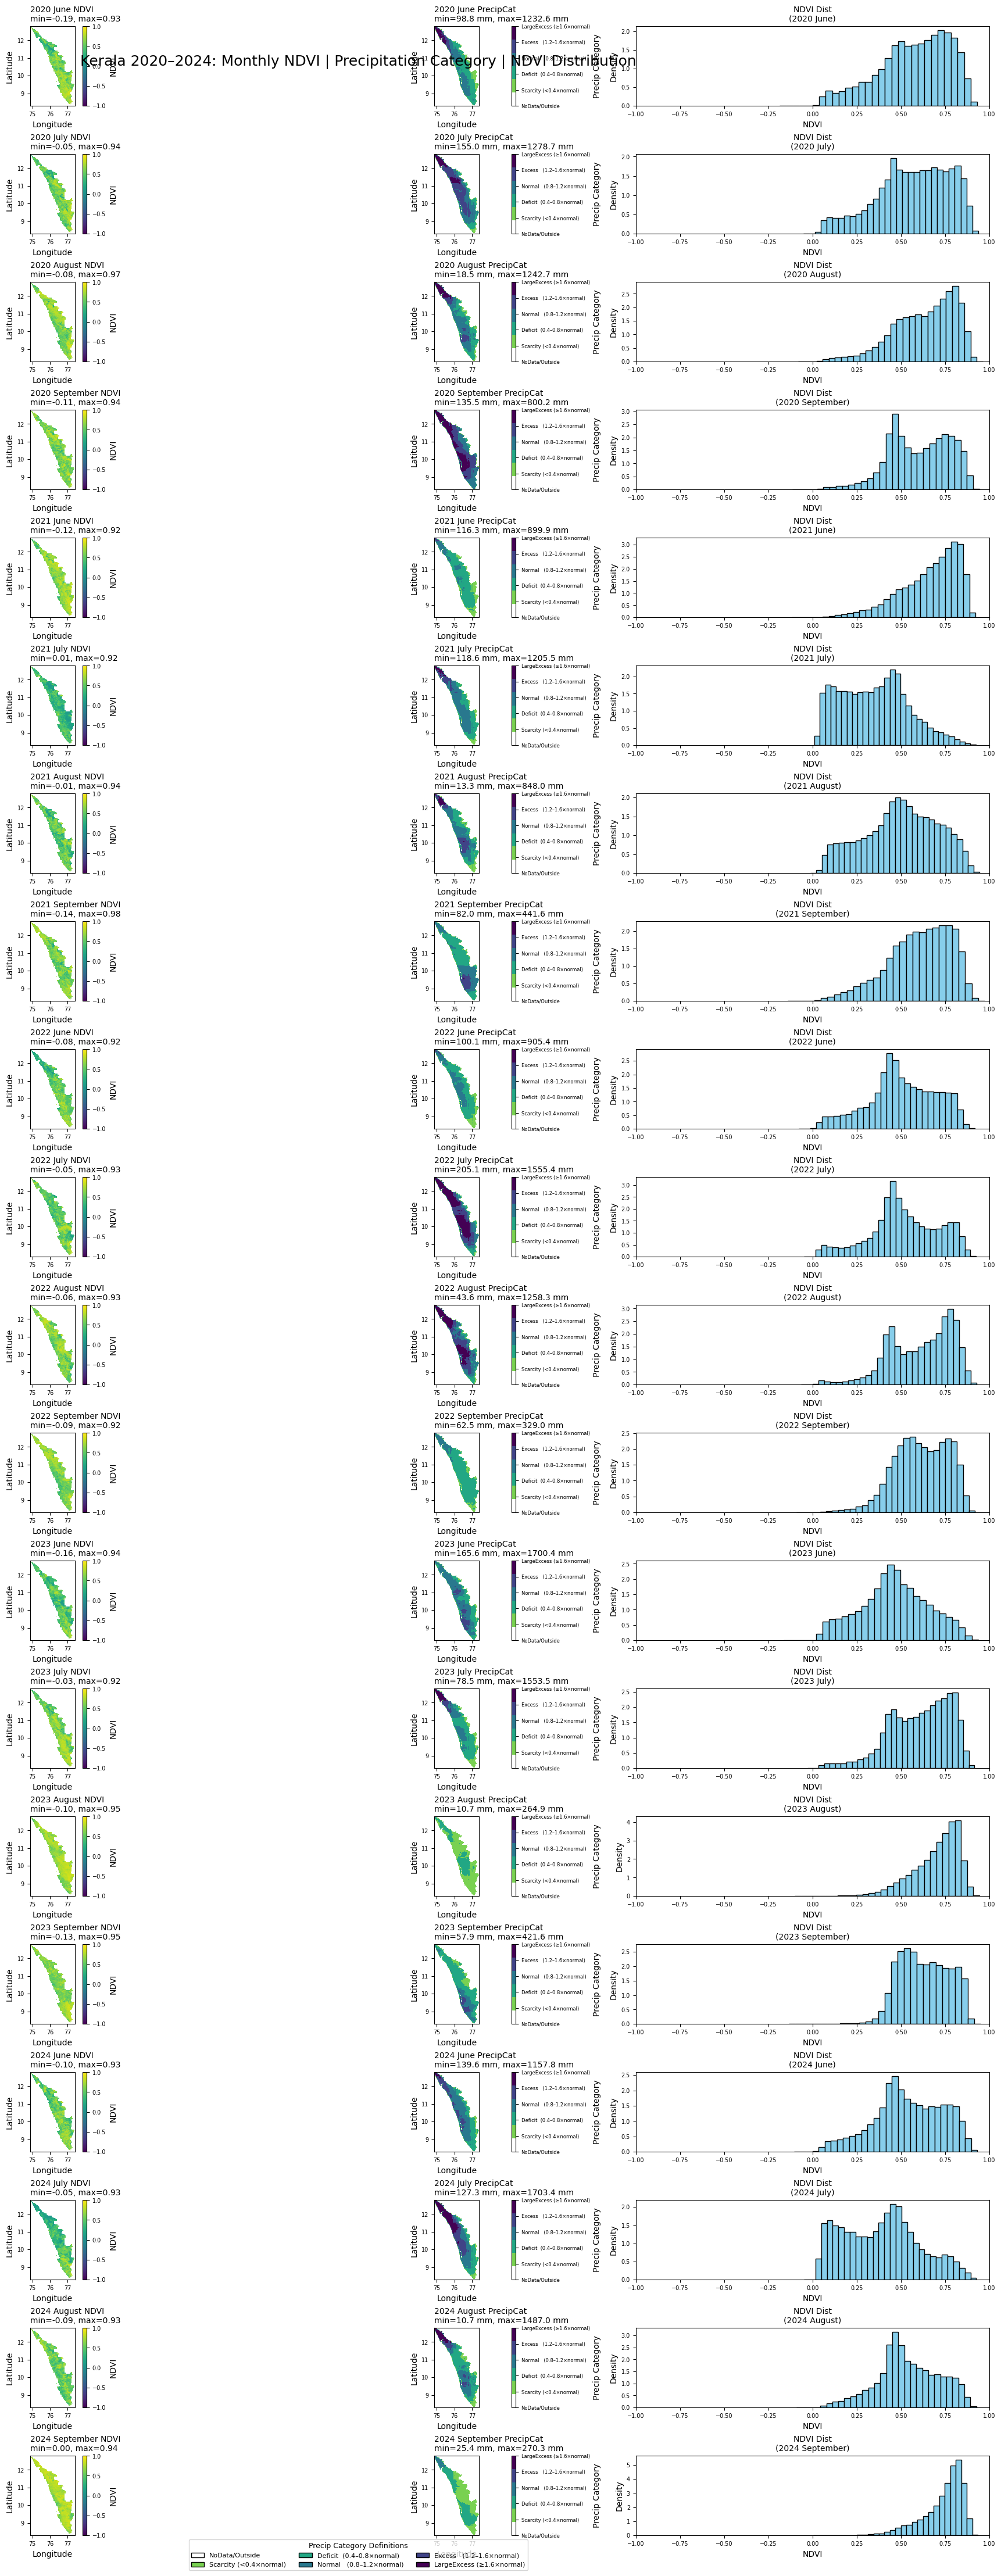

In [98]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust if needed)
# -----------------------------------------------------------------------------
ndvi_tiff_path       = "Kerala_X_NDVI.tif"
precip_raw_tiff_path = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile      = "SateMask/gadm41_IND_1.shp"  # contains Kerala polygon

for path in (ndvi_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND NDVI TIFF (2020–2024 × 4 months)
# -----------------------------------------------------------------------------
with rasterio.open(ndvi_tiff_path) as src_nd:
    ndvi_bands, _ = rasterio.mask.mask(
        src_nd,
        gpd.read_file(india_shapefile)
           .query("NAME_1 == 'Kerala'")
           .to_crs(src_nd.crs)
           .geometry,
        crop=False, filled=True, nodata=np.nan
    )
    ndvi_bands = ndvi_bands.astype(np.float32)  # shape = (20, H, W)
    ndvi_transform = src_nd.transform
    ndvi_crs       = src_nd.crs
    height, width  = src_nd.height, src_nd.width
    bounds         = src_nd.bounds

if ndvi_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {ndvi_tiff_path}, but found {ndvi_bands.shape[0]}")

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25-BAND RAW PRECIPITATION TIFF (in mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src_pr:
    precip_raw_full, _ = rasterio.mask.mask(
        src_pr,
        gpd.read_file(india_shapefile)
           .query("NAME_1 == 'Kerala'")
           .to_crs(src_pr.crs)
           .geometry,
        crop=False, filled=True, nodata=np.nan
    )
    precip_raw_full = precip_raw_full.astype(np.float32)  # shape = (25, H, W)

if precip_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, but found {precip_raw_full.shape[0]}")

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25-BAND PRECIPITATION CATEGORY TIFF (codes –1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src_pc:
    precip_cat_full, _ = rasterio.mask.mask(
        src_pc,
        gpd.read_file(india_shapefile)
           .query("NAME_1 == 'Kerala'")
           .to_crs(src_pc.crs)
           .geometry,
        crop=False, filled=True, nodata=-1
    )
    precip_cat_full = precip_cat_full.astype(np.int8)  # shape = (25, H, W)

if precip_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, but found {precip_cat_full.shape[0]}")

# -----------------------------------------------------------------------------
# 5) EXTRACT ONLY THE 20 MONTHLY PRECIPITATION BANDS
#    (drop each year's “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_indices = []
for yr_idx in range(5):
    base = yr_idx * 5
    monthly_indices.extend([base + i for i in range(4)])

precip_raw_bands = precip_raw_full[monthly_indices, :, :]  # shape = (20, H, W)
precip_cat_bands = precip_cat_full[monthly_indices, :, :]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & STATISTICS
# -----------------------------------------------------------------------------
# NDVI colormap
ndvi_cmap = plt.get_cmap("viridis")
ndvi_vmin, ndvi_vmax = -1.0, 1.0

# Precipitation category colormap
cluster_colors = [
    "#ffffff",  # 0 = NoData/Outside
    "#79d151",  # 1 = Scarcity
    "#22a784",  # 2 = Deficit
    "#29788e",  # 3 = Normal
    "#404387",  # 4 = Excess
    "#440154"   # 5 = LargeExcess
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total, ncols=3,
    figsize=(22, n_total * 2.2),
    constrained_layout=True
)
fig.suptitle(
    "Kerala 2020–2024: Monthly NDVI | Precipitation Category | NDVI Distribution",
    fontsize=18, y=0.98
)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    yr_idx = i // n_months
    mo_idx = i % n_months
    year   = years[yr_idx]
    month  = month_names[mo_idx]

    # NDVI map
    ndvi_layer = ndvi_bands[i]
    valid_ndvi = ndvi_layer[~np.isnan(ndvi_layer)]
    ndvi_min = float(np.nanmin(valid_ndvi)) if valid_ndvi.size else None
    ndvi_max = float(np.nanmax(valid_ndvi)) if valid_ndvi.size else None

    ax0 = axes[i, 0]
    im0 = ax0.imshow(
        ndvi_layer, cmap=ndvi_cmap, vmin=ndvi_vmin, vmax=ndvi_vmax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    title0 = f"{year} {month} NDVI"
    if ndvi_min is not None:
        title0 += f"\nmin={ndvi_min:.2f}, max={ndvi_max:.2f}"
    ax0.set_title(title0, fontsize=10, loc="left")
    ax0.set_xlabel("Longitude"); ax0.set_ylabel("Latitude"); ax0.tick_params(labelsize=7)
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.045, pad=0.02)
    c0.set_label("NDVI"); c0.ax.tick_params(labelsize=7)

    # Precip category map
    raw_pr = precip_raw_bands[i]
    valid_pr = raw_pr[~np.isnan(raw_pr)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else None
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else None

    raw_clust = precip_cat_bands[i]
    clust_plot = np.zeros(raw_clust.shape, dtype=np.int8)
    mask_val = raw_clust != -1
    clust_plot[mask_val] = raw_clust[mask_val] + 1

    ax1 = axes[i, 1]
    im1 = ax1.imshow(clust_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    title1 = f"{year} {month} PrecipCat"
    if pr_min is not None:
        title1 += f"\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm"
    ax1.set_title(title1, fontsize=10, loc="left")
    ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude"); ax1.tick_params(labelsize=7)
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5]); c1.set_ticklabels([cluster_labels[k] for k in range(6)], fontsize=6); c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Category")

    # NDVI distribution histogram
    ax2 = axes[i, 2]
    if valid_ndvi.size > 0:
        ax2.hist(valid_ndvi.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(ndvi_vmin, ndvi_vmax)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8,color="gray")
    ax2.set_title(f"NDVI Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("NDVI"); ax2.set_ylabel("Density"); ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 9) LEGEND FOR PRECIPITATION CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles, loc="lower center", ncol=3, frameon=True,
           title="Precip Category Definitions", bbox_to_anchor=(0.5,-0.005), fontsize=8, title_fontsize=9)

plt.show()


In [ ]:
##Kerala_X_Relative_Humidity

In [ ]:

// --------------------------------------------------------------------------------
// Compute Monthly‐Mean Relative Humidity for Kerala (June–September, 2020–2024)
// using ERA5‐Land Hourly data. Stack all 20 months into one 20‐band GeoTIFF
// named “Kerala_X_Relative_Humidity.tif”.
// --------------------------------------------------------------------------------

// 0. Load Indian states boundary and filter for Kerala
var states = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala Boundary');

// 1. Define the years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 2. Define visualization parameters for Relative Humidity (0–100%)
//    with an eight‐color reversed palette (very high RH → red down to blue)
var visRH = {
  min:    0,
  max:  100,
  palette: [
    'red',       // very high RH
    'orange',
    'yellow',
    'white',
    'green',
    'cyan',
    'lightblue',
    'blue'       // very low RH
  ]
};

// 3. Function to compute daily RH from ERA5‐Land fields
function computeDailyRH(image) {
  var t2m  = image.select('temperature_2m');
  var td2m = image.select('dewpoint_temperature_2m');
  var T  = t2m.subtract(273.15);
  var Td = td2m.subtract(273.15);
  var a = 17.625, b = 243.04;
  var eTd = Td.multiply(a).divide(Td.add(b)).exp();
  var eT  = T.multiply(a).divide(T.add(b)).exp();
  return eTd.divide(eT).multiply(100).rename('RH')
             .copyProperties(image, image.propertyNames());
}

// 4. Loop over each year & month to compute monthly‐mean RH
var allBands = [];

years.forEach(function(year) {
  months.forEach(function(m, idx) {
    // 4.1 Define start and end dates for this month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');

    // 4.2 Filter ERA5‐Land Hourly to this month & Kerala, compute daily RH
    var era5Daily = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
                       .filterDate(start, end)
                       .filterBounds(kerala)
                       .select(['temperature_2m', 'dewpoint_temperature_2m'])
                       .map(computeDailyRH)
                       .select('RH');

    // 4.3 Compute the monthly mean RH, clip to Kerala, rename band
    var monthlyRH = era5Daily
                      .mean()
                      .clip(kerala)
                      .rename(year + '_' + monthNames[idx] + '_RH');

    allBands.push(monthlyRH);

    // 4.4 Visualize each monthly RH on the map
    Map.addLayer(
      monthlyRH,
      visRH,
      year + ' ' + monthNames[idx] + ' RH (%)'
    );
  });
});

// 5. Stack all 20 monthly RH bands into one multi‐band image
var rhMultiband = ee.Image.cat(allBands);

// 6. Export the 20‐band RH image to Google Drive
Export.image.toDrive({
  image:          rhMultiband,
  description:    'Kerala_X_Relative_Humidity',  // Task name
  folder:         'GEE_Exports',                 // Drive folder
  fileNamePrefix: 'Kerala_X_Relative_Humidity',  // Output → “Kerala_X_Relative_Humidity.tif”
  region:         kerala.geometry(),             // Clip to Kerala boundary
  scale:          1000,                          // 1 km resolution
  crs:            'EPSG:4326',
  maxPixels:      1e13
});


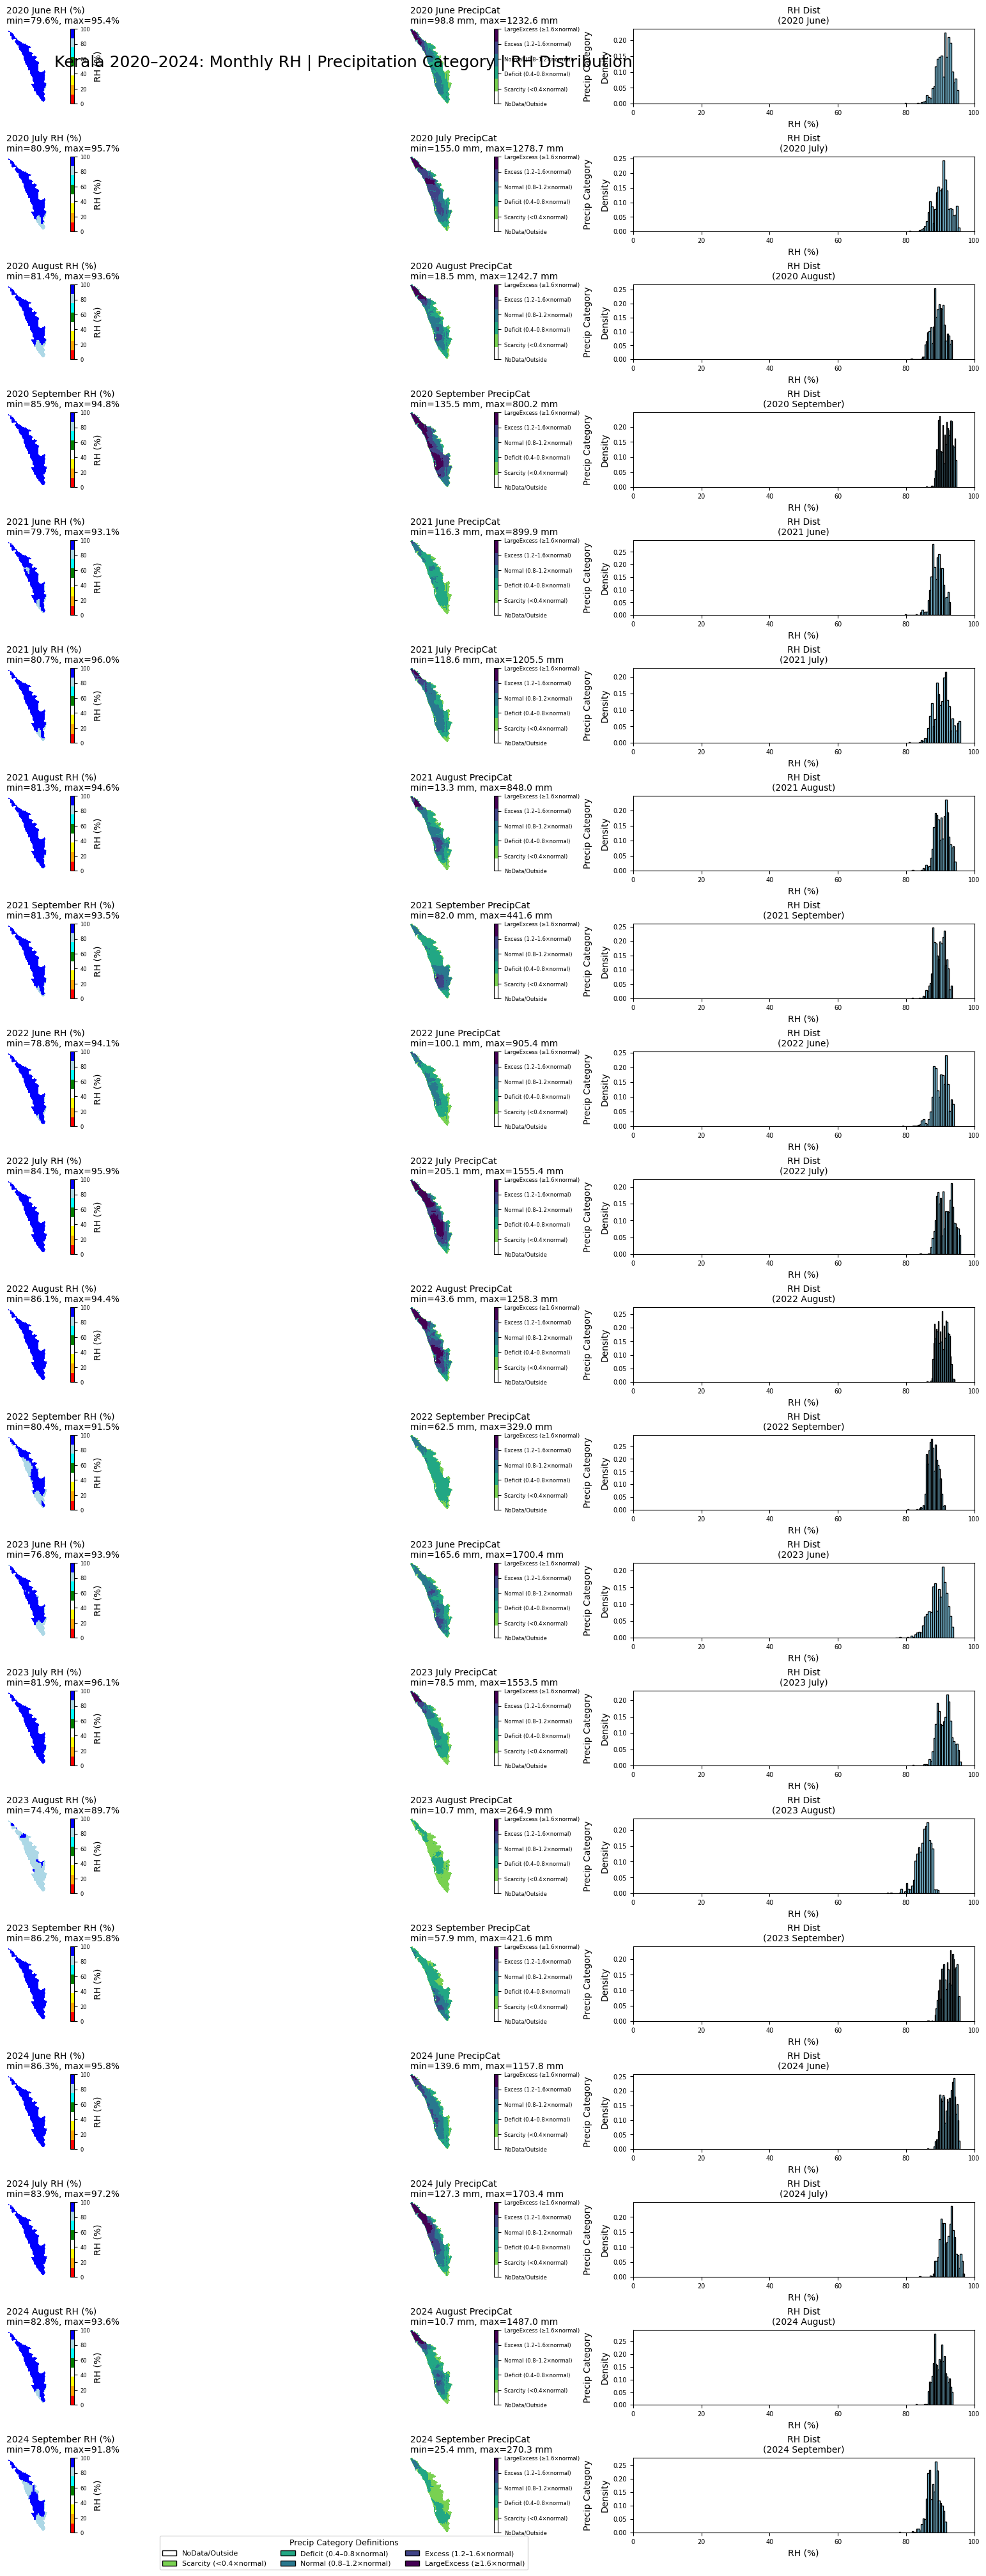

In [102]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust if needed)
# -----------------------------------------------------------------------------
#  - Relative Humidity TIFF:       20 bands (June–Sept 2020–2024)
#  - Raw Precipitation TIFF:       25 bands (2020–2024 × 5: Jun, Jul, Aug, Sep, Total)
#  - Precipitation Category TIFF:  25 bands (2020–2024 × 5 category bands)
#  - Kerala mask shapefile:        "SateMask/gadm41_IND_1.shp"  (contains all Indian states)
# -----------------------------------------------------------------------------
rh_tiff_path        = "Kerala_X_Relative_Humidity.tif"
precip_raw_tiff     = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff     = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile     = "SateMask/gadm41_IND_1.shp"

for path in (rh_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND RELATIVE HUMIDITY TIFF
# -----------------------------------------------------------------------------
with rasterio.open(rh_tiff_path) as src_rh:
    rh_bands      = src_rh.read().astype(np.float32)  # shape = (20, H, W)
    rh_transform  = src_rh.transform
    rh_crs        = src_rh.crs
    height, width = src_rh.height, src_rh.width
    rh_bounds     = src_rh.bounds

if rh_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {rh_tiff_path}, but found {rh_bands.shape[0]}")

# 2a) Load Kerala from the shapefile and reproject to match RH CRS
gdf = gpd.read_file(india_shapefile)
gdf_kerala = gdf[gdf["NAME_1"].str.lower() == "kerala"].copy()
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")

if gdf_kerala.crs != rh_crs:
    gdf_kerala = gdf_kerala.to_crs(rh_crs)

# 2b) Build a single unioned geometry for Kerala
kerala_geom = [gdf_kerala.geometry.union_all()]

# 2c) Create a boolean mask where True = inside Kerala
kerala_mask = geometry_mask(
    kerala_geom,
    transform=rh_transform,
    invert=True,
    out_shape=(height, width)
)

# 2d) Set RH pixels outside Kerala → NaN
for i in range(rh_bands.shape[0]):
    band = rh_bands[i]
    band[~kerala_mask] = np.nan
    rh_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25‐BAND RAW PRECIPITATION TIFF (in mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src_pr_raw:
    pr_raw_full = src_pr_raw.read().astype(np.float32)  # shape = (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}, but found {pr_raw_full.shape[0]}")

# 3a) Mask raw precipitation outside Kerala → NaN
for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~kerala_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25‐BAND PRECIPITATION CATEGORY TIFF (codes -1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src_pr_cat:
    pr_cat_full = src_pr_cat.read().astype(np.int8)  # shape = (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}, but found {pr_cat_full.shape[0]}")

# 4a) Mask precipitation categories outside Kerala → code = -1
for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~kerala_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT THE 20 MONTHLY PRECIP BANDS
#    (drop each year's “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_indices = []
for y in range(5):
    base = y * 5
    monthly_indices.extend([base, base+1, base+2, base+3])

pr_raw_bands = pr_raw_full[monthly_indices, :, :]  # shape = (20, H, W)
pr_cat_bands = pr_cat_full[monthly_indices, :, :]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & GLOBAL STATISTICS
# -----------------------------------------------------------------------------
# 7a) Relative Humidity colormap (8-step reversed)
rh_palette = ["red","orange","yellow","white","green","cyan","lightblue","blue"]
rh_cmap = ListedColormap(rh_palette)
rh_vmin, rh_vmax = 0, 100

# 7b) Precipitation category colormap
cluster_colors = [
    "#ffffff","#79d151","#22a784","#29788e","#404387","#440154"
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside", 1: "Scarcity (<0.4×normal)", 2: "Deficit (0.4–0.8×normal)",
    3: "Normal (0.8–1.2×normal)", 4: "Excess (1.2–1.6×normal)", 5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# 7c) Global min/max of raw precipitation
all_pr = pr_raw_bands.flatten()
all_pr = all_pr[~np.isnan(all_pr)]
pr_vmin = float(np.nanmin(all_pr)) if all_pr.size else 0.0
pr_vmax = float(np.nanmax(all_pr)) if all_pr.size else 0.0

# -----------------------------------------------------------------------------
# 8) CREATE THE FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total, ncols=3,
    figsize=(20, n_total * 2.0),
    constrained_layout=True
)
fig.suptitle(
    "Kerala 2020–2024: Monthly RH | Precipitation Category | RH Distribution",
    fontsize=18, y=0.98
)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    yr_idx = i // n_months
    mo_idx = i % n_months
    year   = years[yr_idx]
    month  = month_names[mo_idx]

    # (a) RH layer & stats
    rh_layer = rh_bands[i]
    valid_rh = rh_layer[~np.isnan(rh_layer)]
    rh_min = float(np.nanmin(valid_rh)) if valid_rh.size else None
    rh_max = float(np.nanmax(valid_rh)) if valid_rh.size else None

    ax0 = axes[i, 0]
    im0 = ax0.imshow(rh_layer, cmap=rh_cmap, vmin=rh_vmin, vmax=rh_vmax,
                     extent=[rh_bounds.left,rh_bounds.right,rh_bounds.bottom,rh_bounds.top],
                     origin="upper")
    title0 = f"{year} {month} RH (%)"
    if rh_min is not None:
        title0 += f"\nmin={rh_min:.1f}%, max={rh_max:.1f}%"
    ax0.set_title(title0, fontsize=10, loc="left")
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.045, pad=0.02)
    c0.set_label("RH (%)"); c0.ax.tick_params(labelsize=6)

    # (b) Precip category map & stats
    pr_layer = pr_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else None
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else None

    cat_layer = pr_cat_bands[i]
    cat_plot  = np.zeros(cat_layer.shape, dtype=np.int8)
    mask_val  = cat_layer != -1
    cat_plot[mask_val] = cat_layer[mask_val] + 1

    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[rh_bounds.left,rh_bounds.right,rh_bounds.bottom,rh_bounds.top],
                     origin="upper")
    title1 = f"{year} {month} PrecipCat"
    if pr_min is not None:
        title1 += f"\nmin={pr_min:.1f} mm, max={pr_max:.1f} mm"
    ax1.set_title(title1, fontsize=10, loc="left")
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[k] for k in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Category")

    # (c) RH Distribution histogram
    ax2 = axes[i, 2]
    if valid_rh.size > 0:
        ax2.hist(valid_rh.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(rh_vmin, rh_vmax)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8,color="gray")
    ax2.set_title(f"RH Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("RH (%)"); ax2.set_ylabel("Density"); ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 9) Legend for Precipitation Categories
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles, loc="lower center", ncol=3, frameon=True,
           title="Precip Category Definitions", bbox_to_anchor=(0.5,-0.005),
           fontsize=8, title_fontsize=9)

plt.show()


In [ ]:
##Kerala_X_Wind_Speed

In [ ]:
// --------------------------------------------------------------------------------
// Compute Monthly‐Mean Wind Speed for Kerala (June–September, 2020–2024)
// using ERA5‐Land Hourly data (“ECMWF/ERA5_LAND/HOURLY”). We will produce
// 5 years × 4 months = 20 single‐band images, stack them into a single 20‐band
// GeoTIFF, and export as “Kerala_X_Wind_Speed.tif”.
// --------------------------------------------------------------------------------

// 1. Load Kerala boundary from GAUL level1 and display it
var states = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala Boundary');

// 2. Define the years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 3. Visualization parameters for wind speed (m/s)
var visWind = {
  min:     0.0,
  max:     8.0,
  palette: ['white', 'cyan', 'blue', 'purple']
};

// 4. Build a list of single‐band wind‐speed images (one per year & month)
var allBands = [];

years.forEach(function(year) {
  months.forEach(function(m, idx) {
    // 4a. Define start/end dates for this month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');

    // 4b. Load ERA5‐Land Hourly for this month & Kerala, selecting 10 m wind components
    var era5 = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY")
                  .filterDate(start, end)
                  .filterBounds(kerala)
                  .select(['u_component_of_wind_10m', 'v_component_of_wind_10m']);

    // 4c. Compute wind speed = sqrt(u² + v²) for each hourly image
    var windSpeedColl = era5.map(function(img) {
      var u = img.select('u_component_of_wind_10m');
      var v = img.select('v_component_of_wind_10m');
      return u.pow(2).add(v.pow(2)).sqrt()
              .rename('wind_speed')
              .copyProperties(img, img.propertyNames());
    });

    // 4d. Compute monthly mean wind speed, clip to Kerala, rename band
    var monthlyAvg = windSpeedColl
                       .mean()
                       .clip(kerala)
                       .rename(year + '_' + monthNames[idx] + '_Wind');

    allBands.push(monthlyAvg);

    // 4e. Visualize each monthly wind‐speed layer on the map
    Map.addLayer(
      monthlyAvg,
      visWind,
      year + ' ' + monthNames[idx] + ' Wind Speed (m/s)'
    );
  });
});

// 5. Stack all 20 monthly bands into one multi‐band Image
var windMultiband = ee.Image.cat(allBands);

// 6. Export the 20‐band wind‐speed image to Google Drive
Export.image.toDrive({
  image:          windMultiband,
  description:    'Kerala_X_Wind_Speed',    // Task name (no spaces)
  folder:         'GEE_Exports',            // Drive folder; change if desired
  fileNamePrefix: 'Kerala_X_Wind_Speed',    // Output → “Kerala_X_Wind_Speed.tif”
  region:         kerala.geometry(),        // Clip to Kerala boundary
  scale:          1000,                     // 1 km resolution
  crs:            'EPSG:4326',
  maxPixels:      1e13
});

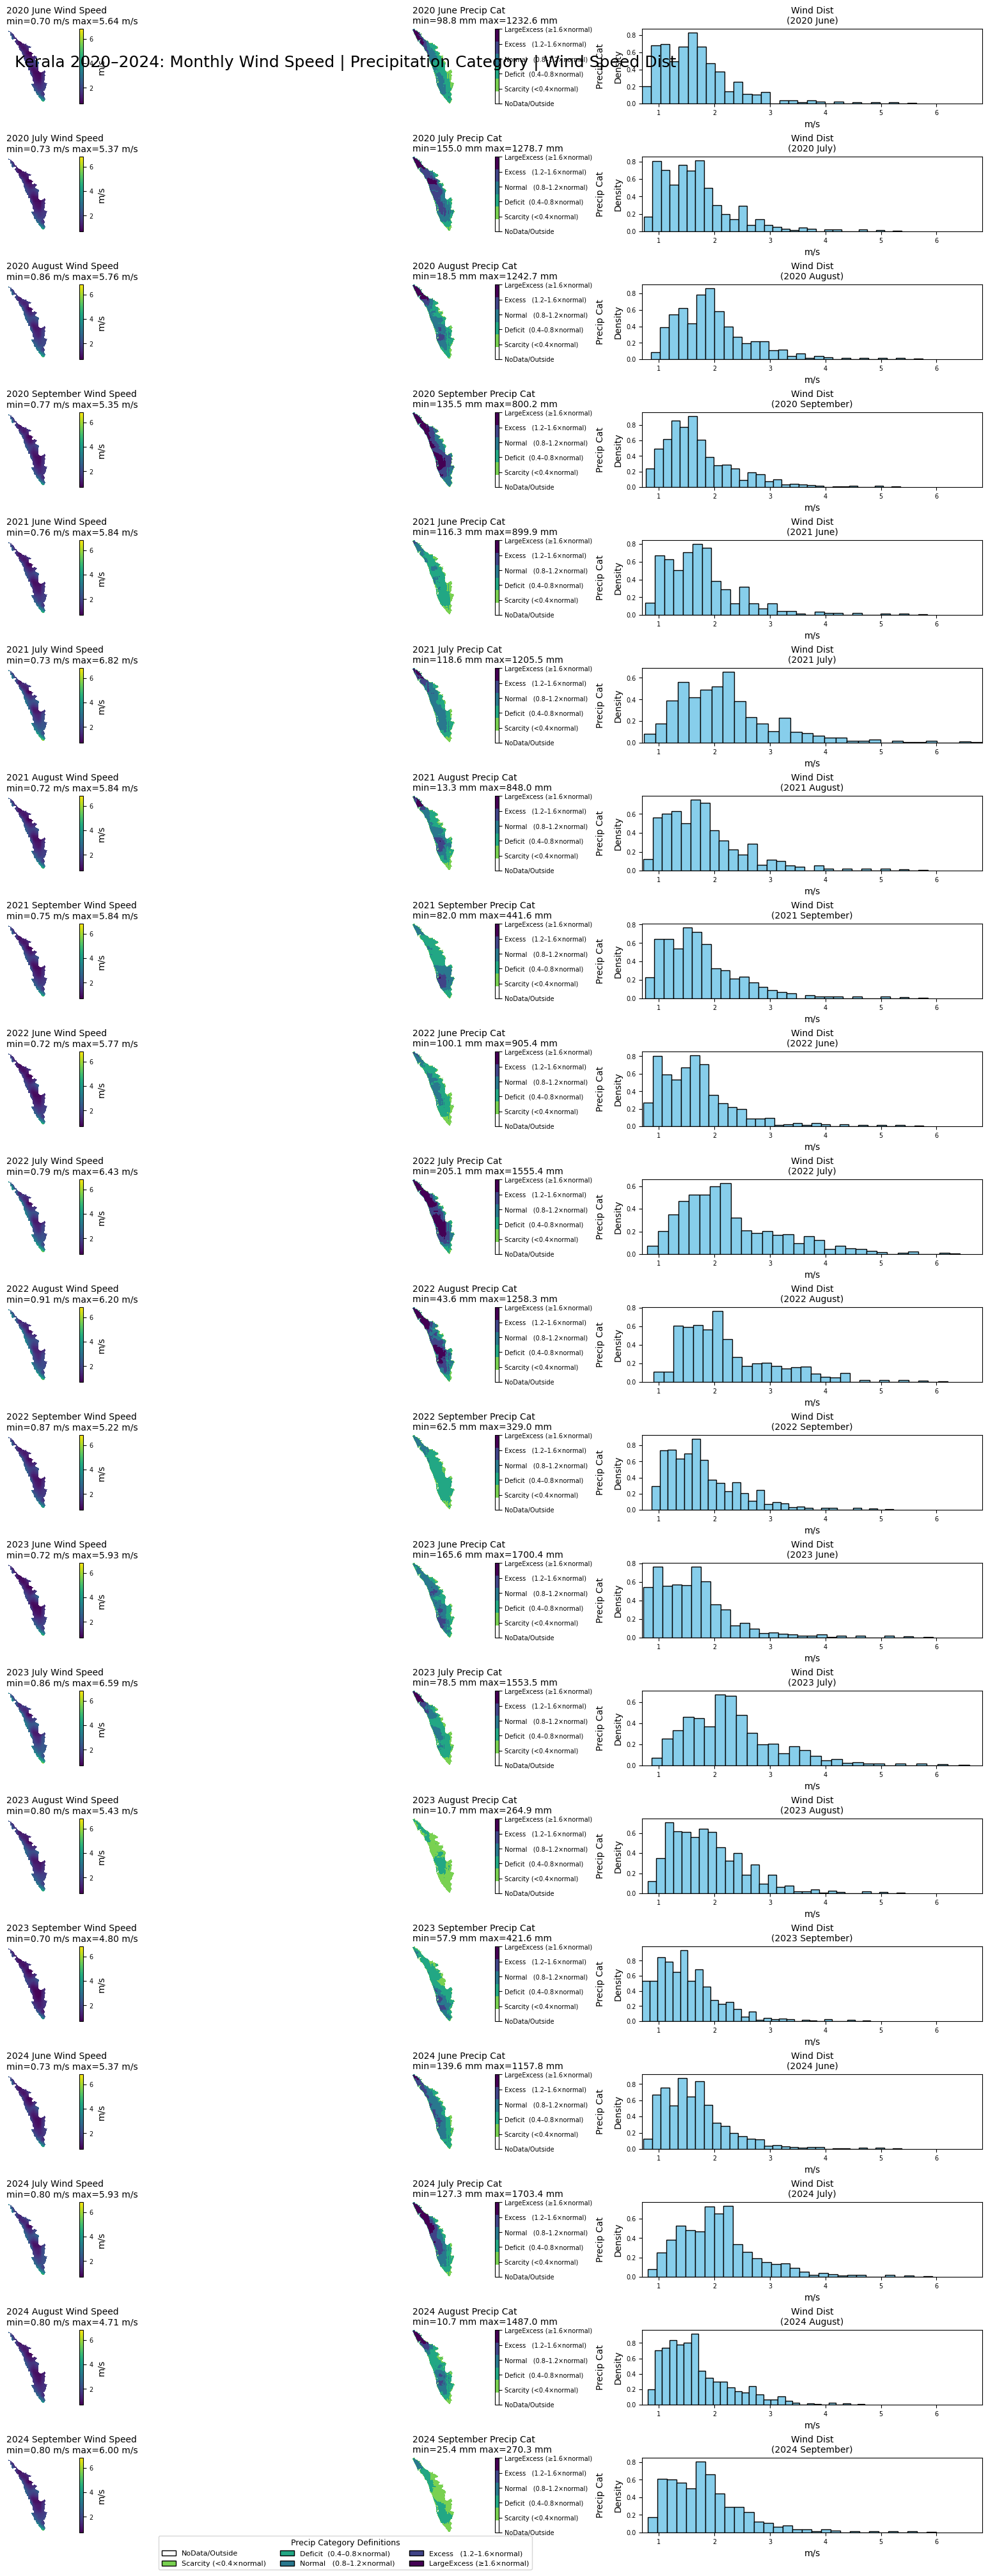

In [106]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust if needed)
#    - Wind Speed TIFF:       20 bands (2020–2024 × 4 months: June, July, August, September)
#    - Raw Precip TIFF (CHIRPS): 25 bands (2020–2024 × 5 bands/year: Jun, Jul, Aug, Sep, Total)
#    - Precip Category TIFF: 25 bands (same order, codes –1..4)
#    - Kerala shapefile:      "SateMask/gadm41_IND_1.shp" (vector mask of all Indian states)
# -----------------------------------------------------------------------------
wind_tiff_path        = "Kerala_X_Wind_Speed.tif"
precip_raw_tiff_path  = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"

for p in (wind_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND WIND SPEED TIFF
# -----------------------------------------------------------------------------
with rasterio.open(wind_tiff_path) as src_wind:
    wind_bands     = src_wind.read().astype(np.float32)  # shape = (20, H, W)
    wind_transform = src_wind.transform
    wind_crs       = src_wind.crs
    height, width  = src_wind.height, src_wind.width
    bounds         = src_wind.bounds

n_wind_bands = wind_bands.shape[0]
if n_wind_bands != 20:
    raise ValueError(f"Expected 20 bands in {wind_tiff_path}, but found {n_wind_bands}")

# 2a) Load Kerala from the shapefile & reproject to match wind CRS
gdf = gpd.read_file(india_shapefile)
gdf_kerala = gdf[gdf["NAME_1"].str.lower() == "kerala"].copy()
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")

if gdf_kerala.crs != wind_crs:
    gdf_kerala = gdf_kerala.to_crs(wind_crs)

# 2b) Build a single geometry for Kerala
kerala_geom = [gdf_kerala.geometry.union_all()]

# 2c) Create boolean mask: True = inside Kerala
kerala_mask = geometry_mask(
    kerala_geom,
    transform=wind_transform,
    invert=True,
    out_shape=(height, width)
)

# 2d) Mask wind bands outside Kerala → NaN
for i in range(n_wind_bands):
    band = wind_bands[i]
    band[~kerala_mask] = np.nan
    wind_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25‐BAND RAW PRECIPITATION TIFF (CHIRPS, units: mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src_pr:
    pr_raw_full = src_pr.read().astype(np.float32)  # shape = (25, H, W)

n_pr_raw_bands = pr_raw_full.shape[0]
if n_pr_raw_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, but found {n_pr_raw_bands}")

# 3a) Mask raw precipitation outside Kerala → NaN
for i in range(n_pr_raw_bands):
    arr = pr_raw_full[i]
    arr[~kerala_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25‐BAND PRECIPITATION CATEGORY TIFF (codes –1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src_pc:
    pr_cat_full = src_pc.read().astype(np.int8)  # shape = (25, H, W)

n_pr_cat_bands = pr_cat_full.shape[0]
if n_pr_cat_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, but found {n_pr_cat_bands}")

# 4a) Mask precip categories outside Kerala → code = -1
for i in range(n_pr_cat_bands):
    arr = pr_cat_full[i]
    arr[~kerala_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT THE 20‐MONTHLY PRECIPITATION BANDS
#    (drop each year's “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_indices = []
for year_idx in range(5):
    base = year_idx * 5
    monthly_indices.extend([base + 0, base + 1, base + 2, base + 3])

pr_raw_bands = pr_raw_full[monthly_indices, :, :]  # shape = (20, H, W)
pr_cat_bands = pr_cat_full[monthly_indices, :, :]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & GLOBAL STATISTICS
# -----------------------------------------------------------------------------
# 7a) Wind speed colormap & range
valid_ws = wind_bands.flatten()[~np.isnan(wind_bands.flatten())]
wind_vmin = float(np.nanmin(valid_ws)) if valid_ws.size else 0.0
wind_vmax = float(np.nanmax(valid_ws)) if valid_ws.size else 1.0
wind_cmap = plt.get_cmap("viridis")

# 7b) Precip category colormap
cluster_colors = [
    "#ffffff",  # 0 = NoData/Outside
    "#79d151",  # 1 = Scarcity
    "#22a784",  # 2 = Deficit
    "#29788e",  # 3 = Normal
    "#404387",  # 4 = Excess
    "#440154"   # 5 = LargeExcess
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total,
    ncols=3,
    figsize=(20, n_total * 2.0),
    constrained_layout=True
)
fig.suptitle(
    "Kerala 2020–2024: Monthly Wind Speed | Precipitation Category | Wind Speed Dist",
    fontsize=18, y=0.98
)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    yr_idx   = i // n_months
    mo_idx   = i % n_months
    year     = years[yr_idx]
    month    = month_names[mo_idx]

    # (a) Wind speed layer & stats
    ws_layer = wind_bands[i]
    valid_ws = ws_layer[~np.isnan(ws_layer)]
    ws_min = float(np.nanmin(valid_ws)) if valid_ws.size else np.nan
    ws_max = float(np.nanmax(valid_ws)) if valid_ws.size else np.nan

    ax0 = axes[i, 0]
    im0 = ax0.imshow(ws_layer, cmap=wind_cmap, vmin=wind_vmin, vmax=wind_vmax,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    ax0.set_title(f"{year} {month} Wind Speed\nmin={ws_min:.2f} m/s max={ws_max:.2f} m/s",
                  loc="left", fontsize=10)
    ax0.axis("off")
    cbar0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.045, pad=0.02)
    cbar0.set_label("m/s"); cbar0.ax.tick_params(labelsize=7)

    # (b) Precip category map & stats
    pr_layer = pr_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan

    raw_cat = pr_cat_bands[i]
    cat_plot = np.zeros(raw_cat.shape, np.int8)
    mask_val = (raw_cat != -1)
    cat_plot[mask_val] = raw_cat[mask_val] + 1

    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    ax1.set_title(f"{year} {month} Precip Cat\nmin={pr_min:.1f} mm max={pr_max:.1f} mm",
                  loc="left", fontsize=10)
    ax1.axis("off")
    cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.045, pad=0.02)
    cbar1.set_ticks([0,1,2,3,4,5])
    cbar1.set_ticklabels([cluster_labels[i] for i in range(6)], fontsize=7)
    cbar1.set_label("Precip Cat")

    # (c) Wind speed distribution
    ax2 = axes[i, 2]
    if valid_ws.size:
        ax2.hist(valid_ws.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(wind_vmin, wind_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"Wind Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("m/s"); ax2.set_ylabel("Density"); ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) ADD LEGEND FOR PRECIPITATION CATEGORIES
# -----------------------------------------------------------------------------
fig.legend(handles=cluster_handles, loc="lower center", ncol=3, frameon=True,
           title="Precip Category Definitions", bbox_to_anchor=(0.5, -0.005),
           fontsize=8, title_fontsize=9)

plt.show()


In [ ]:
##Kerala_X_LULC

In [ ]:
// --------------------------------------------------------------------------------
// Compute Monthly‐Mode LULC for Kerala (June–September, 2020–2024)
// using Google’s Dynamic World (“GOOGLE/DYNAMICWORLD/V1”). We will produce
// 5 years × 4 months = 20 single‐band images, stack them into one 20‐band
// GeoTIFF, and export it as “Kerala_X_LULC.tif”.
// --------------------------------------------------------------------------------

// 1. Load Kerala boundary from GAUL level1 and display it
var states   = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala   = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala Boundary');

// 2. Define the years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 3. Build a list of single‐band LULC mode images (one per year & month)
var allBands = [];

// 3a. Loop over each year
years.forEach(function(year) {
  // 3b. Loop over each monsoon month
  months.forEach(function(m, idx) {
    // 3b.1 Define start/end dates for this month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');

    // 3b.2 Load Dynamic World for that month & filter to Kerala
    var dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
                .filterDate(start, end)
                .filterBounds(kerala);

    // 3b.3 Compute the pixel‐wise mode of 'label', rename & clip
    var modeImg = dw
                    .select('label')
                    .mode()
                    .rename(year + '_' + monthNames[idx] + '_LULC')
                    .clip(kerala);

    // 3b.4 Print min/max classes to the Console for verification
    var stats = modeImg.reduceRegion({
      reducer:    ee.Reducer.minMax(),
      geometry:   kerala.geometry(),
      scale:      1000,
      bestEffort: true
    });
    print(year + ' ' + monthNames[idx] + ' LULC mode min/max:', stats);

    // 3b.5 Add this single‐band image to our list
    allBands.push(modeImg);

    // 3b.6 (Optional) Visualize on the map using the DW palette
    /*
    Map.addLayer(
      modeImg,
      {
        min:     0,
        max:     8,
        palette: [
          '419bdf', // Water
          '397d49', // Trees
          '88b053', // Grass
          '7a87c6', // Flooded Vegetation
          'e49635', // Crops
          'dfc35a', // Shrub & Scrub
          'c4281b', // Built-Up
          'a59b8f', // Bare Ground
          'b39fe1'  // Snow & Ice
        ]
      },
      year + ' ' + monthNames[idx] + ' LULC Mode'
    );
    */
  });
});

// 4. Stack all 20 monthly bands into one multi‐band Image
var lulcStack = ee.Image.cat(allBands);

// 5. Rename bands explicitly to maintain chronological order
var bandNames20 = [];
years.forEach(function(year) {
  monthNames.forEach(function(mn) {
    bandNames20.push(year + '_' + mn + '_LULC');
  });
});
lulcStack = lulcStack.rename(bandNames20);

// 6. Export the 20‐band LULC image to Google Drive
Export.image.toDrive({
  image:          lulcStack,
  description:    'Kerala_X_LULC',    // Task name
  folder:         'GEE_Exports',      // Drive folder
  fileNamePrefix: 'Kerala_X_LULC',    // Output file “Kerala_X_LULC.tif”
  region:         kerala.geometry(),  
  scale:          1000,               // 1 km resolution
  crs:            'EPSG:4326',
  maxPixels:      1e13
});


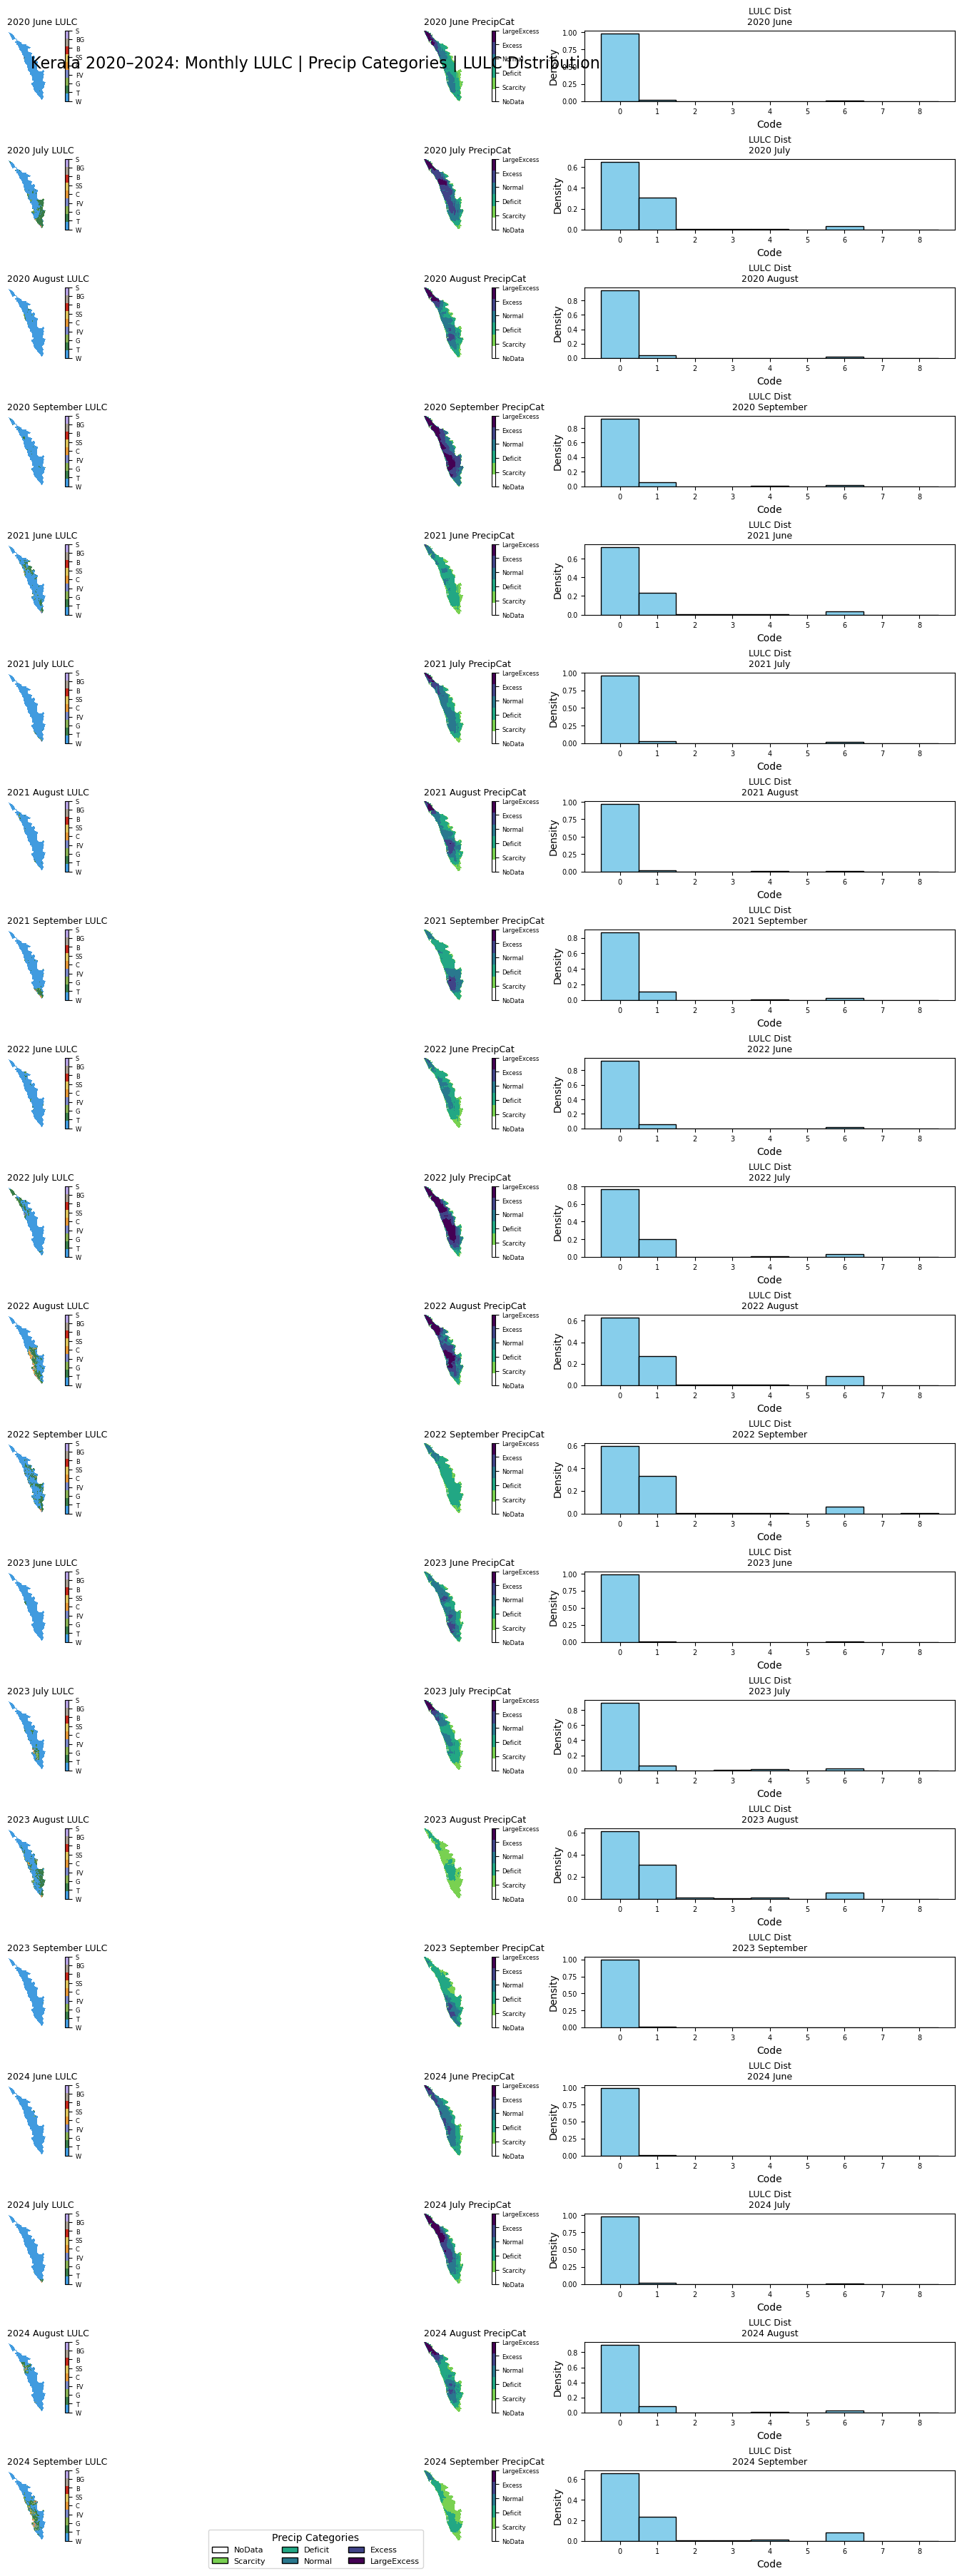

In [112]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust if needed)
# -----------------------------------------------------------------------------
lulc_tiff_path        = "Kerala_X_LULC.tif"
precip_raw_tiff_path  = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"  # contains Kerala polygon

for path in (lulc_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND LULC TIFF
# -----------------------------------------------------------------------------
with rasterio.open(lulc_tiff_path) as src:
    lulc_bands     = src.read().astype(np.float32)  # (20, H, W)
    transform      = src.transform
    crs            = src.crs
    height, width  = src.height, src.width
    bounds         = src.bounds

n_bands = lulc_bands.shape[0]
if n_bands != 20:
    raise ValueError(f"Expected 20 bands in {lulc_tiff_path}, but found {n_bands}")

# 2a) Load Kerala from shapefile & reproject
gdf = gpd.read_file(india_shapefile)
gdf_kerala = gdf[gdf["NAME_1"].str.lower() == "kerala"].copy()
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")
if gdf_kerala.crs != crs:
    gdf_kerala = gdf_kerala.to_crs(crs)

# 2b) Build unioned geometry & mask
kerala_geom = [gdf_kerala.geometry.union_all()]
mask = geometry_mask(kerala_geom, transform=transform, invert=True, out_shape=(height, width))

# 2c) Mask outside → NaN
for i in range(n_bands):
    band = lulc_bands[i]
    band[~mask] = np.nan
    lulc_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK 25‐BAND RAW PRECIP TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    raw_pr = src.read().astype(np.float32)
if raw_pr.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}")
for i in range(25):
    arr = raw_pr[i]
    arr[~mask] = np.nan
    raw_pr[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK 25‐BAND PRECIP CATEGORY TIFF
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    cat_pr = src.read().astype(np.int8)
if cat_pr.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}")
for i in range(25):
    arr = cat_pr[i]
    arr[~mask] = -1
    cat_pr[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT 20 MONTHLY PRECIP BANDS (drop each year's 5th)
# -----------------------------------------------------------------------------
monthly_idx = []
for y in range(5):
    base = y * 5
    monthly_idx.extend([base + i for i in range(4)])
pr_raw_bands = raw_pr[monthly_idx]
pr_cat_bands = cat_pr[monthly_idx]

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(months)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) COLORMAPS & STATS
# -----------------------------------------------------------------------------
# LULC palette
dw_palette = [
    "#419bdf","#397d49","#88b053","#7a87c6",
    "#e49635","#dfc35a","#c4281b","#a59b8f","#b39fe1"
]
lulc_cmap = ListedColormap(dw_palette)

# Precip category palette
cluster_colors = [
    "#ffffff","#79d151","#22a784","#29788e","#404387","#440154"
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0:"NoData",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# Precip raw vmin/vmax
all_pr = pr_raw_bands.flatten()
all_pr = all_pr[~np.isnan(all_pr)]
pr_vmin, pr_vmax = (float(np.min(all_pr)), float(np.max(all_pr))) if all_pr.size else (0,0)

# -----------------------------------------------------------------------------
# 8) PLOT: 20 ROWS × 3 COLS
# Col0=LULC, Col1=PrecipCat, Col2=LULC histogram
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=n_total, ncols=3, figsize=(18, n_total*1.8), constrained_layout=True)
fig.suptitle("Kerala 2020–2024: Monthly LULC | Precip Categories | LULC Distribution", fontsize=16, y=0.98)

if n_total==1:
    axes = axes[np.newaxis,:]

for i in range(n_total):
    yidx, midx = divmod(i, n_months)
    year, mon = years[yidx], months[midx]

    # LULC map
    lc = lulc_bands[i]
    ax0 = axes[i,0]
    im0 = ax0.imshow(lc, cmap=lulc_cmap, vmin=0, vmax=8, extent=[bounds.left,bounds.right,bounds.bottom,bounds.top], origin="upper")
    ax0.set_title(f"{year} {mon} LULC", loc="left", fontsize=9); ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_ticks(range(9)); c0.ax.set_yticklabels(['W','T','G','FV','C','SS','B','BG','S'], fontsize=6)

    # Precip category map
    cat = pr_cat_bands[i]
    plot_cat = np.zeros_like(cat)
    maskv = cat!=-1
    plot_cat[maskv] = cat[maskv]+1
    ax1 = axes[i,1]
    im1 = ax1.imshow(plot_cat, cmap=cluster_cmap, vmin=0, vmax=5, extent=[bounds.left,bounds.right,bounds.bottom,bounds.top], origin="upper")
    ax1.set_title(f"{year} {mon} PrecipCat", loc="left", fontsize=9); ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks(range(6)); c1.set_ticklabels([cluster_labels[i] for i in range(6)], fontsize=6)

    # LULC histogram
    data = lc[~np.isnan(lc)].flatten()
    ax2 = axes[i,2]
    if data.size:
        ax2.hist(data, bins=np.arange(-0.5,9.5,1), density=True, edgecolor="black", color="skyblue")
        ax2.set_xticks(range(9))
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",fontsize=8)
    ax2.set_title(f"LULC Dist\n{year} {mon}", fontsize=9)
    ax2.set_xlabel("Code"); ax2.set_ylabel("Density"); ax2.tick_params(labelsize=7)

# Legend for precip categories
fig.legend(handles=cluster_handles, loc="lower center", ncol=3, frameon=True, title="Precip Categories", bbox_to_anchor=(0.5,0), fontsize=8)

plt.show()


In [ ]:
##Kerala_X_Soil_Moisture

In [ ]:
// --------------------------------------------------------------------------------
// Compute Monthly‐Mean Soil Moisture for Kerala (June–September, 2020–2024)
// using ERA5-Land Daily Aggregates (“ECMWF/ERA5_LAND/DAILY_AGGR”). We will produce
// 5 years × 4 months = 20 single-band images, stack them into one 20-band GeoTIFF,
// and export as “Kerala_X_Soil_Moisture.tif”.
// --------------------------------------------------------------------------------

// 1. Load Kerala boundary from GAUL level1 and display it
var states = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala Boundary');

// 2. Define the years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 3. Build a list of single-band soil-moisture images (one per year & month)
var allBands = [];

// 3a. Loop over each year
years.forEach(function(year) {
  // 3b. Loop over each monsoon month (6 = June, 7 = July, 8 = August, 9 = September)
  months.forEach(function(m, idx) {
    // 3b.1 Define start/end dates for this month
    var start = ee.Date.fromYMD(year, m, 1);
    var end   = start.advance(1, 'month');

    // 3b.2 Load ERA5-Land Daily Aggregates for this month & Kerala,
    //       selecting layer 1 soil moisture
    var smColl = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
                    .filterDate(start, end)
                    .filterBounds(kerala)
                    .select('volumetric_soil_water_layer_1');

    // 3b.3 Compute monthly mean soil moisture, clip to Kerala, rename band
    var monthlySM = smColl
                      .mean()
                      .clip(kerala)
                      .rename(year + '_' + monthNames[idx] + '_SM');

    // 3b.4 (Optional) Print min/max to the Console for verification
    var stats = monthlySM.reduceRegion({
      reducer:    ee.Reducer.minMax(),
      geometry:   kerala.geometry(),
      scale:      1000,
      bestEffort: true
    });
    print(year + ' ' + monthNames[idx] + ' Soil Moisture min/max:', stats);

    // 3b.5 Add this single-band image to the list
    allBands.push(monthlySM);

    // 3b.6 (Optional) Visualize each monthly soil-moisture layer on the map
    Map.addLayer(
      monthlySM,
      {
        min: 0.05,
        max: 0.55,
        palette: ['white', 'lightblue', 'navyblue', 'blue', 'darkblue']
      },
      year + ' ' + monthNames[idx] + ' Soil Moisture'
    );
  });
});

// 4. Stack all 20 monthly bands into one multi-band Image
var soilMoistureMultiband = ee.Image.cat(allBands);

// 5. Export the 20-band soil-moisture image to Google Drive
Export.image.toDrive({
  image:          soilMoistureMultiband,
  description:    'Kerala_X_Soil_Moisture',   // Task name (no spaces)
  folder:         'GEE_Exports',              // Drive folder
  fileNamePrefix: 'Kerala_X_Soil_Moisture',   // Result → “Kerala_X_Soil_Moisture.tif”
  region:         kerala.geometry(),          // Clip to Kerala boundary
  scale:          1000,                       // 1 km resolution
  crs:            'EPSG:4326',
  maxPixels:      1e13
});


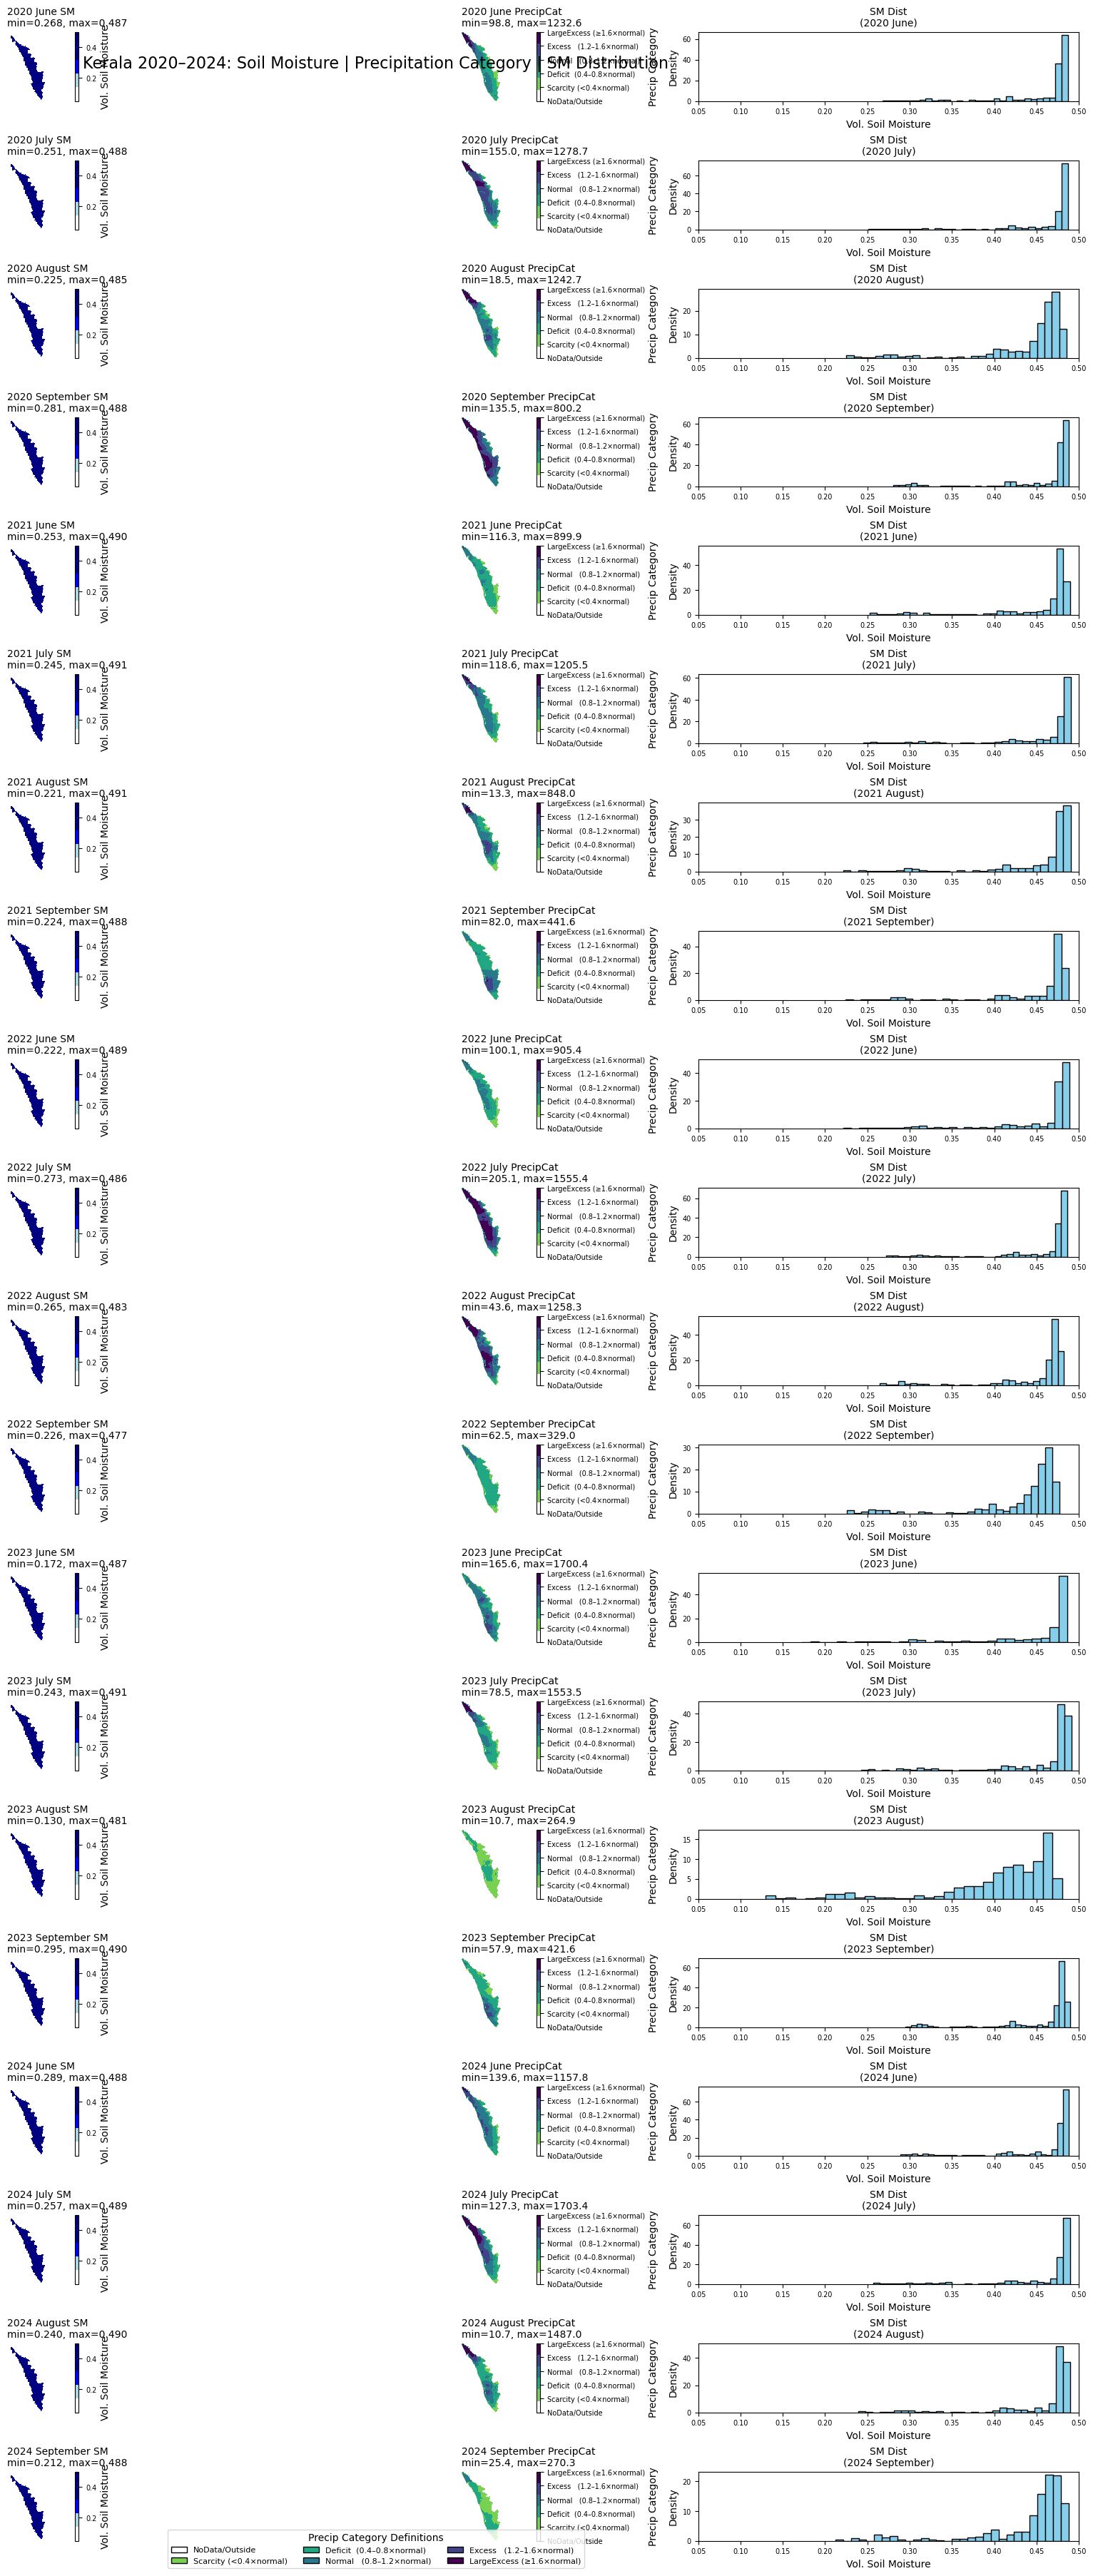

In [116]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust as needed)
#    - Soil Moisture TIFF:          20 bands (2020–2024 × 4 months: June, July, August, September)
#    - Raw Precipitation TIFF:      25 bands (2020–2024 × 5 bands each: June, July, August, September, Total)
#    - Precipitation Category TIFF: 25 bands (2020–2024 × 5 category bands)
#    - Kerala mask shapefile:       "SateMask/gadm41_IND_1.shp"
# -----------------------------------------------------------------------------
sm_tiff_path        = "Kerala_X_Soil_Moisture.tif"
precip_raw_tiff     = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff     = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile     = "SateMask/gadm41_IND_1.shp"

for path in (sm_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Cannot find {path!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20-BAND SOIL MOISTURE TIFF
# -----------------------------------------------------------------------------
with rasterio.open(sm_tiff_path) as src_sm:
    sm_bands      = src_sm.read().astype(np.float32)  # shape = (20, H, W)
    sm_transform  = src_sm.transform
    sm_crs        = src_sm.crs
    height, width = src_sm.height, src_sm.width
    bounds        = src_sm.bounds

n_sm_bands = sm_bands.shape[0]
if n_sm_bands != 20:
    raise ValueError(f"Expected 20 bands in {sm_tiff_path}, but found {n_sm_bands}")

# 2a) Load Kerala polygon from India shapefile & reproject to SM CRS
gdf = gpd.read_file(india_shapefile)
gdf_kerala = gdf[gdf["NAME_1"].str.lower() == "kerala"].copy()
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")
if gdf_kerala.crs != sm_crs:
    gdf_kerala = gdf_kerala.to_crs(sm_crs)

# 2b) Build a single unioned geometry for Kerala
kerala_geom = [gdf_kerala.geometry.union_all()]

# 2c) Create boolean mask: True = inside Kerala
kerala_mask = geometry_mask(
    kerala_geom,
    transform=sm_transform,
    invert=True,
    out_shape=(height, width)
)

# 2d) Mask soil moisture bands outside Kerala → NaN
for i in range(n_sm_bands):
    band = sm_bands[i]
    band[~kerala_mask] = np.nan
    sm_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25-BAND RAW PRECIPITATION TIFF (in mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src_pr:
    pr_raw_full = src_pr.read().astype(np.float32)  # shape = (25, H, W)

n_pr_raw = pr_raw_full.shape[0]
if n_pr_raw != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}, but found {n_pr_raw}")

for i in range(n_pr_raw):
    arr = pr_raw_full[i]
    arr[~kerala_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25-BAND PRECIPITATION CATEGORY TIFF (codes -1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src_pc:
    pr_cat_full = src_pc.read().astype(np.int8)  # shape = (25, H, W)

n_pr_cat = pr_cat_full.shape[0]
if n_pr_cat != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}, but found {n_pr_cat}")

for i in range(n_pr_cat):
    arr = pr_cat_full[i]
    arr[~kerala_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT ONLY THE 20 MONTHLY PRECIP BANDS
#    (drop each year's “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_idx = []
for y in range(5):
    base = y * 5
    monthly_idx.extend([base, base+1, base+2, base+3])

pr_raw = pr_raw_full[monthly_idx, :, :]
pr_cat = pr_cat_full[monthly_idx, :, :]

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & STATISTICS
# -----------------------------------------------------------------------------
# 7a) Soil moisture colormap & range
sm_cmap = ListedColormap(["white","lightblue","blue","darkblue","navy"])
sm_vmin, sm_vmax = 0.05, 0.5

# 7b) Precipitation category colormap
cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
pr_cmap = ListedColormap(cluster_colors)
pr_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
pr_handles = [Patch(facecolor=cluster_colors[i], edgecolor="black", label=pr_labels[i])
              for i in range(len(cluster_colors))]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=n_total, ncols=3, figsize=(20, n_total*1.8), constrained_layout=True)
fig.suptitle("Kerala 2020–2024: Soil Moisture | Precipitation Category | SM Distribution", fontsize=16, y=0.98)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    yr_idx = i // n_months
    mo_idx = i % n_months
    year   = years[yr_idx]
    month  = month_names[mo_idx]

    # Soil moisture
    sm_layer = sm_bands[i]
    valid_sm = sm_layer[~np.isnan(sm_layer)]
    sm_min = float(np.nanmin(valid_sm)) if valid_sm.size else np.nan
    sm_max = float(np.nanmax(valid_sm)) if valid_sm.size else np.nan

    ax0 = axes[i,0]
    im0 = ax0.imshow(sm_layer, cmap=sm_cmap, vmin=sm_vmin, vmax=sm_vmax,
                     extent=[bounds.left,bounds.right,bounds.bottom,bounds.top], origin="upper")
    ax0.set_title(f"{year} {month} SM\nmin={sm_min:.3f}, max={sm_max:.3f}", loc="left", fontsize=10)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.04, pad=0.02)
    c0.set_label("Vol. Soil Moisture")
    c0.ax.tick_params(labelsize=7)

    # Precipitation category
    pr_raw_layer = pr_raw[i]
    valid_pr = pr_raw_layer[~np.isnan(pr_raw_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan

    raw_cat = pr_cat[i]
    cat_plot = np.zeros(raw_cat.shape, np.int8)
    mask = (raw_cat != -1)
    cat_plot[mask] = raw_cat[mask] + 1

    ax1 = axes[i,1]
    im1 = ax1.imshow(cat_plot, cmap=pr_cmap, vmin=0, vmax=5,
                     extent=[bounds.left,bounds.right,bounds.bottom,bounds.top], origin="upper")
    ax1.set_title(f"{year} {month} PrecipCat\nmin={pr_min:.1f}, max={pr_max:.1f}", loc="left", fontsize=10)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([pr_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7)
    c1.set_label("Precip Category")

    # SM distribution
    ax2 = axes[i,2]
    if valid_sm.size:
        ax2.hist(valid_sm.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(sm_vmin, sm_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", color="gray")
    ax2.set_title(f"SM Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("Vol. Soil Moisture")
    ax2.set_ylabel("Density")
    ax2.tick_params(labelsize=7)

# Legend for precip categories
fig.legend(handles=pr_handles, loc="lower center", ncol=3, frameon=True,
           title="Precip Category Definitions", bbox_to_anchor=(0.5,0.00), fontsize=8)
plt.show()


In [ ]:
##Kerala_X_elevation

In [ ]:
// --------------------------------------------------------------------------------
// Compute Monthly‐Mean Elevation for Kerala (June–September, 2020–2024)
// using the SRTM DEM as a static elevation source. Stack all 20 clipped bands into
// one 20‐band GeoTIFF named “Kerala_X_Elevation.tif”.
// --------------------------------------------------------------------------------

// 0. Load Indian states boundary and filter for Kerala
var states = ee.FeatureCollection("FAO/GAUL/2015/level1");
var kerala = states.filter(ee.Filter.eq('ADM1_NAME', 'Kerala'));
Map.centerObject(kerala, 7);
Map.addLayer(kerala, { color: 'black' }, 'Kerala Boundary');

// 1. Define the years (2020–2024) and monsoon months (June–September)
var years      = [2020, 2021, 2022, 2023, 2024];
var months     = [6, 7, 8, 9];
var monthNames = ['June', 'July', 'August', 'September'];

// 2. Load the SRTM elevation dataset (single‐band, static 30 m DEM)
var srtm = ee.Image("USGS/SRTMGL1_003");

// 3. Prepare a list to hold all 20 clipped & renamed elevation bands
var allBands = [];

// 4. Loop over each year & month to clip and rename the elevation band
years.forEach(function(year) {
  months.forEach(function(m, idx) {
    // 4.1 Clip the SRTM DEM to Kerala for this “month”
    var clippedElev = srtm
      .clip(kerala)
      .rename(year + '_' + monthNames[idx] + '_Elev');

    // 4.2 (Optional) Visualize each clipped elevation on the map
    Map.addLayer(
      clippedElev,
      {
        min: 0,
        max: 3000,
        palette: ['blue', 'green', 'yellow', 'brown', 'white']
      },
      year + ' ' + monthNames[idx] + ' Elevation'
    );

    // 4.3 Add the renamed band to our list
    allBands.push(clippedElev);
  });
});

// 5. Stack all 20 clipped elevation bands into one multi‐band image
var elevMultiband = ee.Image.cat(allBands);

// 6. Export the 20‐band Elevation image to Google Drive
Export.image.toDrive({
  image:          elevMultiband,
  description:    'Kerala_X_Elevation',   // Task name
  folder:         'GEE_Exports',          // Drive folder
  fileNamePrefix: 'Kerala_X_Elevation',   // Output → “Kerala_X_Elevation.tif”
  region:         kerala.geometry(),      // Clip to Kerala boundary
  scale:          1000,                   // ~30 m resolution
  crs:            'EPSG:4326',
  maxPixels:      1e13
});


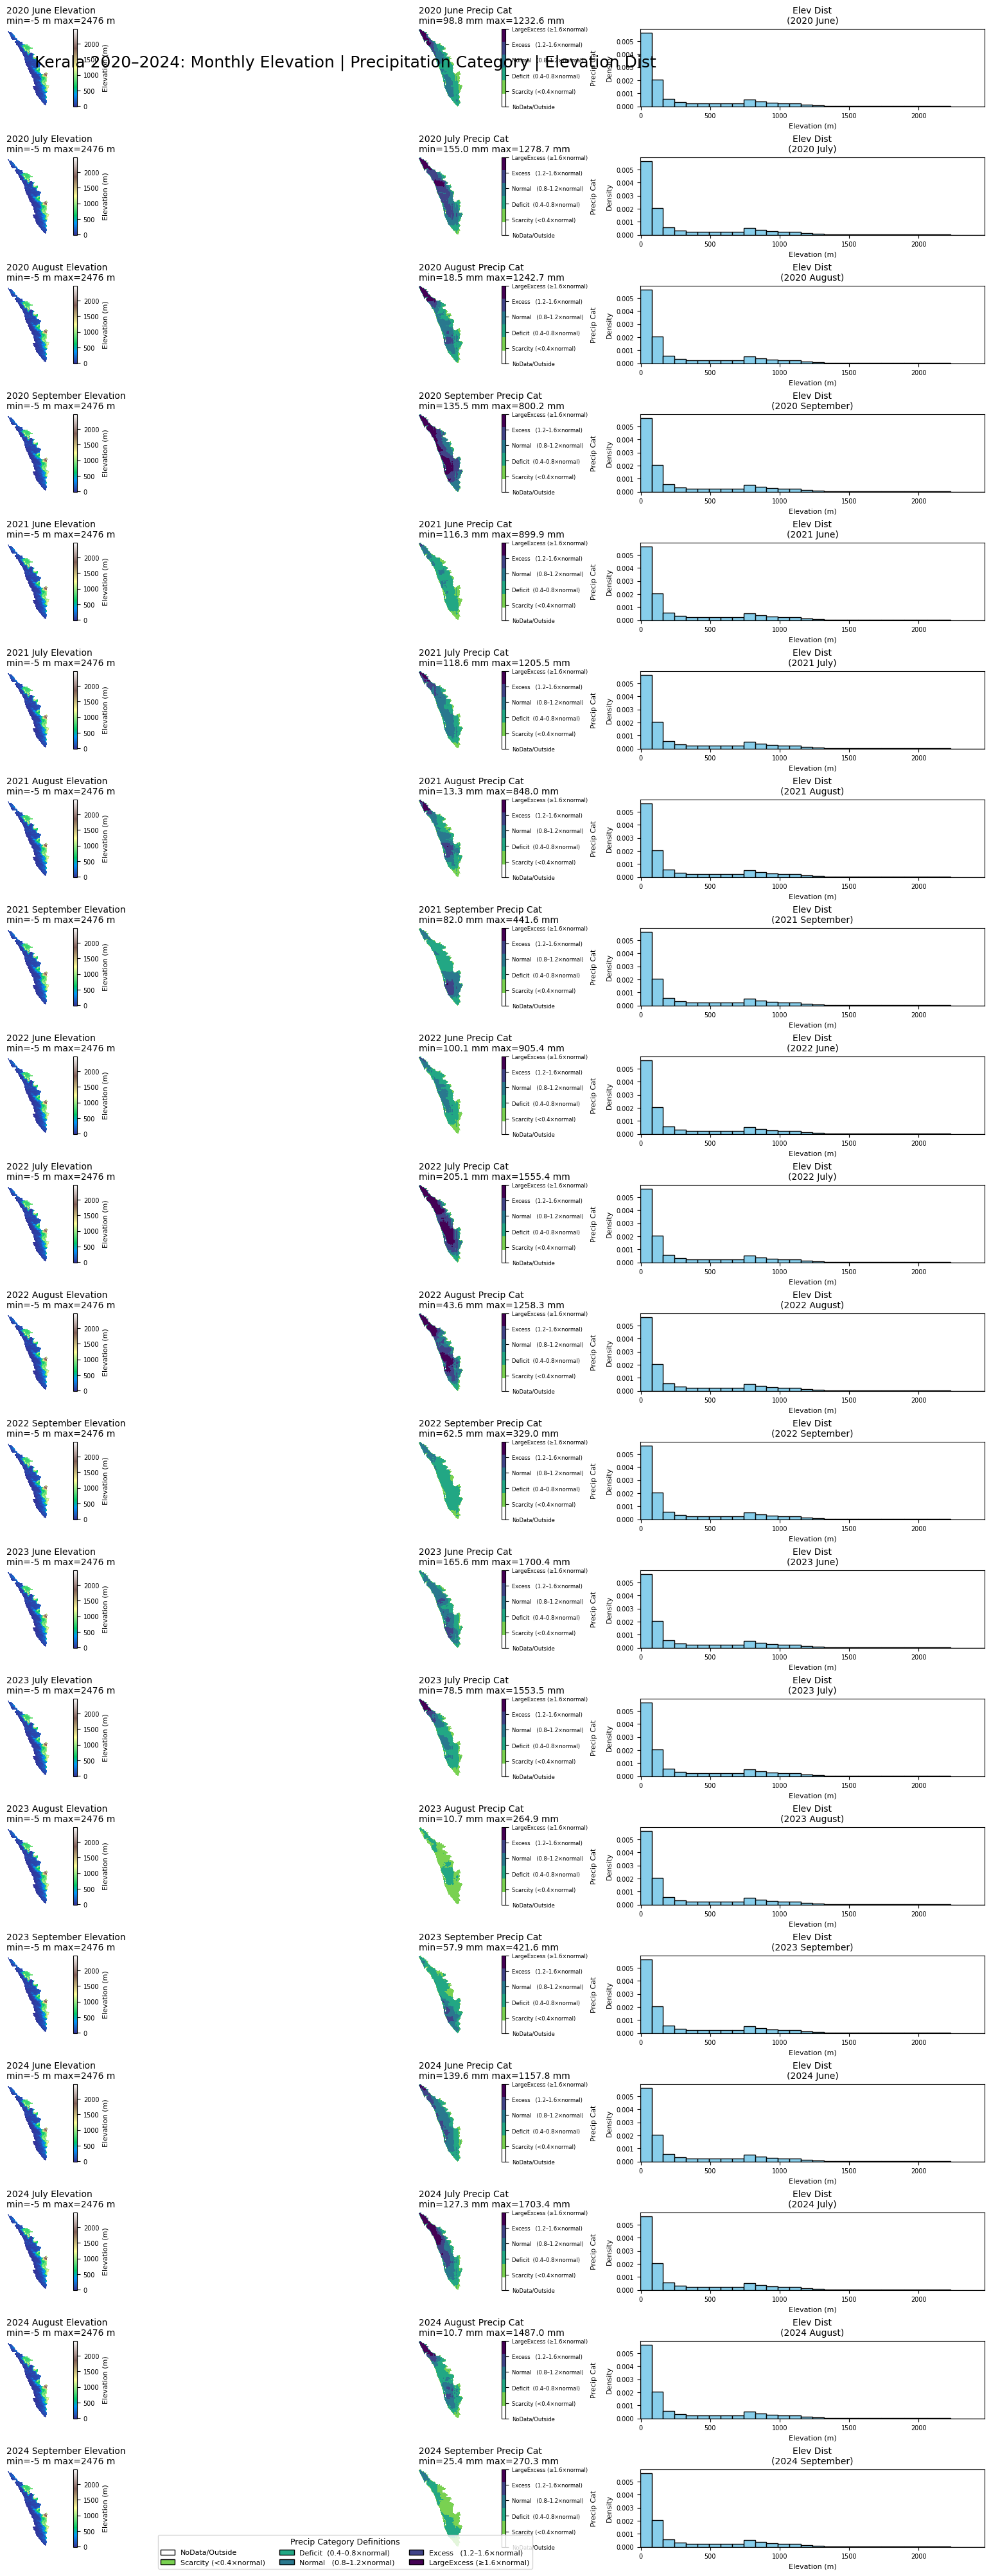

In [122]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (adjust if needed)
#    - Elevation TIFF:      20 bands (2020–2024 × 4 months: June, July, August, September)
#    - Raw Precip TIFF:     25 bands (2020–2024 × 5 bands/year: Jun, Jul, Aug, Sep, Total)
#    - Precip Category TIFF:25 bands (same order, codes –1..4)
#    - Kerala shapefile:    "SateMask/gadm41_IND_1.shp" (vector mask of all states)
# -----------------------------------------------------------------------------
elev_tiff_path        = "Kerala_X_Elevation.tif"
precip_raw_tiff_path  = "Kerala_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff_path  = "Kerala_Y_Precipitation_GT_geotif.tif"
india_shapefile       = "SateMask/gadm41_IND_1.shp"

for p in (elev_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) READ & MASK THE 20‐BAND ELEVATION TIFF (June–September, 2020–2024)
# -----------------------------------------------------------------------------
with rasterio.open(elev_tiff_path) as src_elev:
    elev_bands     = src_elev.read().astype(np.float32)  # shape = (20, H, W)
    elev_transform = src_elev.transform
    elev_crs       = src_elev.crs
    height, width  = src_elev.height, src_elev.width
    bounds         = src_elev.bounds

n_elev_bands = elev_bands.shape[0]
if n_elev_bands != 20:
    raise ValueError(f"Expected 20 bands in {elev_tiff_path}, but found {n_elev_bands}")

# 2a) Load Kerala from the India shapefile and reproject to match elevation CRS
gdf = gpd.read_file(india_shapefile)
gdf_kerala = gdf[gdf["NAME_1"].str.lower() == "kerala"].copy()
if gdf_kerala.empty:
    raise ValueError("No feature named 'Kerala' found in shapefile.")

if gdf_kerala.crs != elev_crs:
    gdf_kerala = gdf_kerala.to_crs(elev_crs)

# 2b) Build a single geometry for Kerala
kerala_geom = [gdf_kerala.geometry.union_all()]

# 2c) Create boolean mask: True = inside Kerala
kerala_mask = geometry_mask(
    kerala_geom,
    transform=elev_transform,
    invert=True,
    out_shape=(height, width)
)

# 2d) Mask elevation outside Kerala → set to NaN
for i in range(n_elev_bands):
    band = elev_bands[i]
    band[~kerala_mask] = np.nan
    elev_bands[i] = band

# -----------------------------------------------------------------------------
# 3) READ & MASK THE 25‐BAND RAW PRECIPITATION TIFF (CHIRPS, units: mm)
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src_pr:
    pr_raw_full = src_pr.read().astype(np.float32)  # shape = (25, H, W)

n_pr_raw_bands = pr_raw_full.shape[0]
if n_pr_raw_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff_path}, but found {n_pr_raw_bands}")

# 3a) Mask raw precipitation outside Kerala → NaN
for i in range(n_pr_raw_bands):
    arr = pr_raw_full[i]
    arr[~kerala_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 4) READ & MASK THE 25‐BAND PRECIPITATION CATEGORY TIFF (codes –1..4)
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src_pc:
    pr_cat_full = src_pc.read().astype(np.int8)  # shape = (25, H, W)

n_pr_cat_bands = pr_cat_full.shape[0]
if n_pr_cat_bands != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff_path}, but found {n_pr_cat_bands}")

# 4a) Mask precip categories outside Kerala → code = -1
for i in range(n_pr_cat_bands):
    arr = pr_cat_full[i]
    arr[~kerala_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 5) EXTRACT THE 20‐MONTHLY PRECIPITATION BANDS
#    (drop each year’s “Total” at indices 4, 9, 14, 19, 24)
# -----------------------------------------------------------------------------
monthly_indices = []
for yr in range(5):
    base = yr * 5
    monthly_indices.extend([base + 0, base + 1, base + 2, base + 3])

pr_raw_bands = pr_raw_full[monthly_indices, :, :]  # shape = (20, H, W)
pr_cat_bands = pr_cat_full[monthly_indices, :, :]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 6) DEFINE YEARS & MONTHS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
month_names = ["June", "July", "August", "September"]
n_years     = len(years)
n_months    = len(month_names)
n_total     = n_years * n_months  # 20

# -----------------------------------------------------------------------------
# 7) PREPARE COLORMAPS & GLOBAL STATISTICS
# -----------------------------------------------------------------------------
# 7a) Elevation colormap & range (ignore NaNs)
all_elev = elev_bands.flatten()
all_elev = all_elev[~np.isnan(all_elev)]
elev_vmin = float(np.nanmin(all_elev)) if all_elev.size else 0.0
elev_vmax = float(np.nanmax(all_elev)) if all_elev.size else 0.0
elev_cmap = plt.get_cmap("terrain")

# 7b) Precipitation category colormap (shift codes -1..4 → 0..5)
cluster_colors = [
    "#ffffff", "#79d151", "#22a784", "#29788e", "#404387", "#440154"
]
cluster_cmap = ListedColormap(cluster_colors)
cluster_labels = {
    0: "NoData/Outside",
    1: "Scarcity (<0.4×normal)",
    2: "Deficit  (0.4–0.8×normal)",
    3: "Normal   (0.8–1.2×normal)",
    4: "Excess   (1.2–1.6×normal)",
    5: "LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(len(cluster_colors))
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE: 20 ROWS × 3 COLUMNS
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=n_total,
    ncols=3,
    figsize=(20, n_total * 2.0),
    constrained_layout=True
)
fig.suptitle(
    "Kerala 2020–2024: Monthly Elevation | Precipitation Category | Elevation Dist",
    fontsize=18, y=0.98
)

if n_total == 1:
    axes = axes[np.newaxis, :]

for i in range(n_total):
    y_idx = i // n_months
    m_idx = i % n_months
    year  = years[y_idx]
    month = month_names[m_idx]

    # Elevation layer & stats
    elev_layer = elev_bands[i]
    valid_e = elev_layer[~np.isnan(elev_layer)]
    elev_min = float(np.nanmin(valid_e)) if valid_e.size else np.nan
    elev_max = float(np.nanmax(valid_e)) if valid_e.size else np.nan

    # Precip raw stats
    pr_layer = pr_raw_bands[i]
    valid_pr = pr_layer[~np.isnan(pr_layer)]
    pr_min = float(np.nanmin(valid_pr)) if valid_pr.size else np.nan
    pr_max = float(np.nanmax(valid_pr)) if valid_pr.size else np.nan

    # Precip category shift
    raw_cat = pr_cat_bands[i]
    cat_plot = np.zeros(raw_cat.shape, dtype=np.int8)
    mask_ok = raw_cat != -1
    cat_plot[mask_ok] = raw_cat[mask_ok] + 1

    # Column 0: Elevation map
    ax0 = axes[i, 0]
    im0 = ax0.imshow(
        elev_layer, cmap=elev_cmap, vmin=elev_vmin, vmax=elev_vmax,
        extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        origin="upper"
    )
    ax0.set_title(f"{year} {month} Elevation\nmin={elev_min:.0f} m max={elev_max:.0f} m",
                  loc="left", fontsize=10)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, orientation="vertical", fraction=0.045, pad=0.02)
    c0.set_label("Elevation (m)", fontsize=8); c0.ax.tick_params(labelsize=7)

    # Column 1: Precip category map
    ax1 = axes[i, 1]
    im1 = ax1.imshow(cat_plot, cmap=cluster_cmap, vmin=0, vmax=5,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
                     origin="upper")
    ax1.set_title(f"{year} {month} Precip Cat\nmin={pr_min:.1f} mm max={pr_max:.1f} mm",
                  loc="left", fontsize=10)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, orientation="vertical", fraction=0.045, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5]); c1.set_ticklabels([cluster_labels[j] for j in range(6)]); c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Cat", fontsize=8)

    # Column 2: Elevation distribution
    ax2 = axes[i, 2]
    if valid_e.size > 0:
        ax2.hist(valid_e.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(elev_vmin, elev_vmax)
    else:
        ax2.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"Elev Dist\n({year} {month})", fontsize=10)
    ax2.set_xlabel("Elevation (m)", fontsize=8); ax2.set_ylabel("Density", fontsize=8); ax2.tick_params(labelsize=7)

# 9) Legend for precipitation categories
fig.legend(handles=cluster_handles, loc="lower center", ncol=3, frameon=True,
           title="Precip Category Definitions", bbox_to_anchor=(0.5, 0.00),
           fontsize=8, title_fontsize=9)

plt.show()
